# Subspace Digital Twin, Parameter Selection Under Uncertainty

*BlockScience, April 2024*

Here we execute the PSUU framework for the subspace economic model. 

For more information see the methodology document by Danilo: https://hackmd.io/iFeP7NemRH--KtWbPP_W0w?view

## Part 1. Architecture Overview

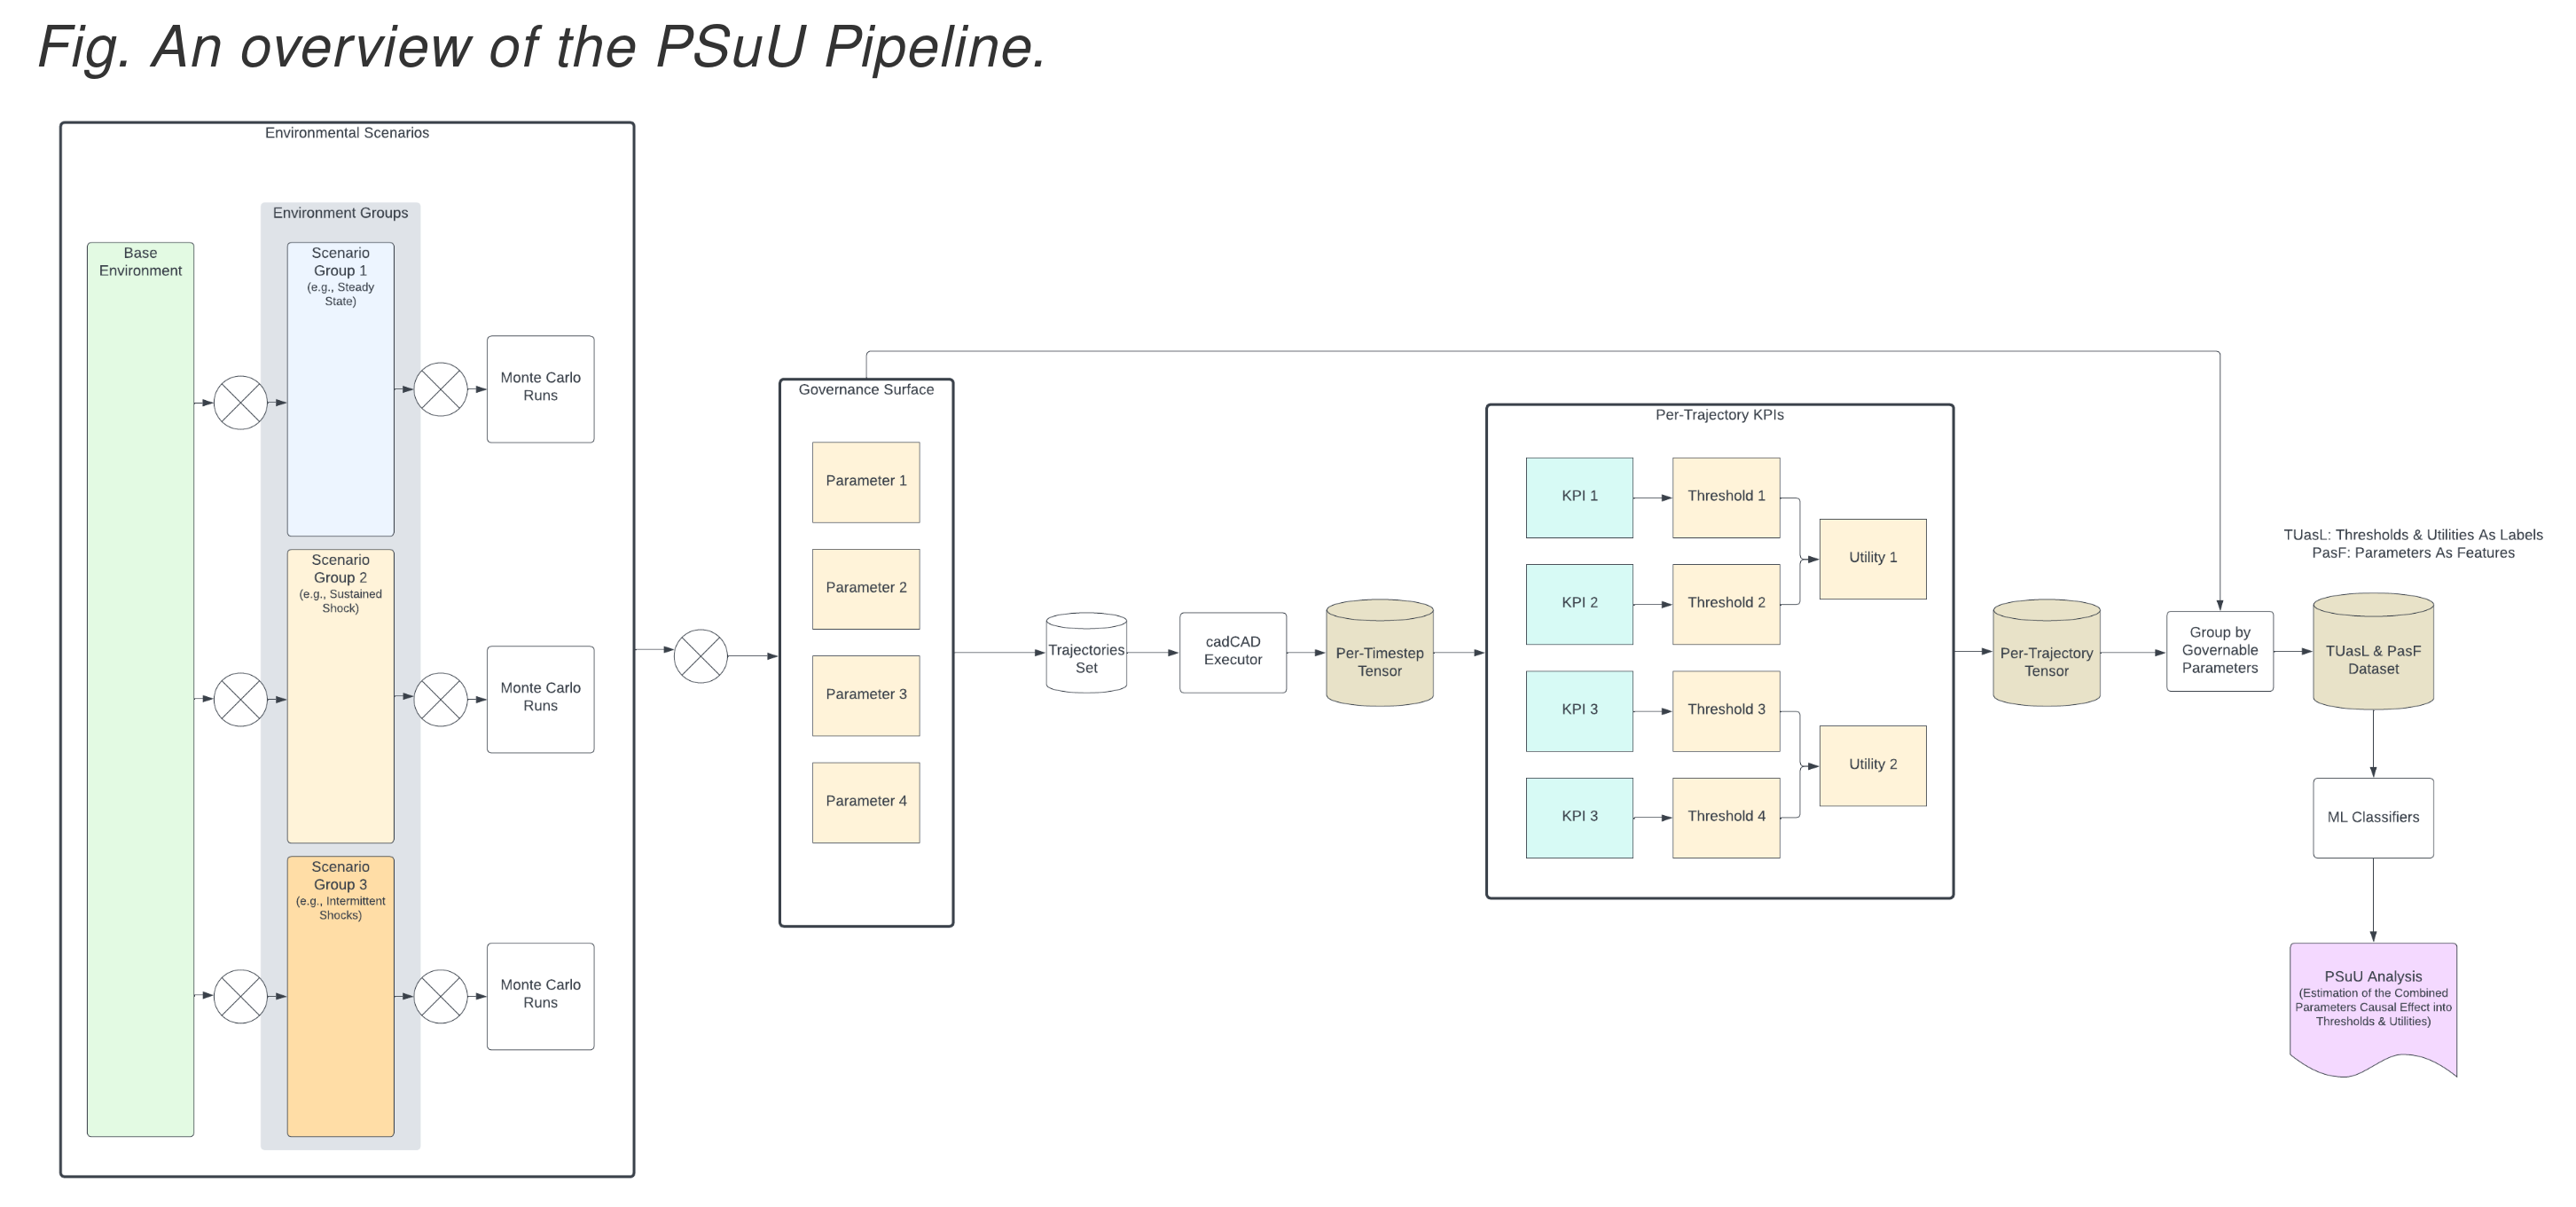

## Part 2. Loading and Cleaning the Per-Timestep Tensor

In [1]:
import sys
sys.path.append('../../')

import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import hvplot.pandas
import holoviews as hv
from typing import Callable, Dict, List, Tuple, Union

from subspace_model.psuu.plots import create_decision_tree_importances_plot
from subspace_model.psuu import timestep_tensor_to_trajectory_tensor, GOVERNANCE_SURFACE_PARAMS
from subspace_model.psuu.kpis import KPI_functions, calculate_goal_score, GOAL_KPI_GROUPS

In [2]:
pd.set_option('display.max_columns', None)

latest = sorted(glob("../../data/simulations/psuu-2024*"))[-1]

sim_df = pd.read_pickle(latest, compression='gzip')

N_sweeps = len(sim_df.subset.unique())
N_runs = len(sim_df.run.unique())
N_trajectories = N_sweeps * N_runs
N_timesteps = len(sim_df.timestep.unique())
N_measurements = N_trajectories * N_timesteps

print(f"Tensor Size: {N_measurements=:,} over {N_trajectories=:,} | ({N_sweeps=:,}, {N_runs=:,}, {N_timesteps=:,})\t")

Tensor Size: N_measurements=8,776,000 over N_trajectories=8,000 | (N_sweeps=400, N_runs=20, N_timesteps=1,097)	


In [3]:
sim_df.days_passed.max()

1096.0

Aggregating trajectories.

In [4]:
agg_df = timestep_tensor_to_trajectory_tensor(sim_df).reset_index()
agg_df.set_index(GOVERNANCE_SURFACE_PARAMS+['subset', 'run']).describe()

simulation  mean_relative_community_owned_supply  \
count       400.0                          4.000000e+02   
mean          0.0                          1.193636e+00   
std           0.0                          3.013895e-08   
min           0.0                          1.193636e+00   
25%           0.0                          1.193636e+00   
50%           0.0                          1.193636e+00   
75%           0.0                          1.193636e+00   
max           0.0                          1.193636e+00   

       mean_farmer_subsidy_factor  \
count                  400.000000   
mean                     0.003085   
std                      0.002468   
min                      0.000218   
25%                      0.001242   
50%                      0.002321   
75%                      0.004419   
max                      0.013695   

       mean_proposing_rewards_per_newly_pledged_space  \
count                                    4.000000e+02   
mean                                     1.835567e-18   
std                                      1.046221e-18   
min                                      5.335418e-19   
25%                                      7.213886e-19   
50%                                      1.609707e-18   
75%                                      2.672975e-18   
max                                      3.623997e-18   

       mean_proposer_reward_minus_voter_reward  cumm_rewards_before_1yr  \
count                               400.000000               400.000000   
mean                                  0.089915               108.220655   
std                                   0.060716                59.037122   
min                                   0.019006                36.515965   
25%                                   0.040072                36.609993   
50%                                   0.095058               109.789975   
75%                                   0.120291               182.773758   
max                                   0.201367               183.855838   

       abs_sum_storage_fees_per_sum_compute_fees  cumm_rewards  
count                                      400.0    400.000000  
mean                                         1.0    325.142629  
std                                          0.0    177.288128  
min                                          1.0    109.730536  
25%                                          1.0    110.204739  
50%                                          1.0    329.838762  
75%                                          1.0    548.889838  
max                                          1.0    552.248326

Kernal density estimate plots of KPI outcomes over trajectories.

Evaluating the utility tensor.

In [5]:


# Type alias for a Criterion function
Criterion = Callable[[float, pd.Series], bool]

def evaluate(x: pd.Series, data: pd.DataFrame, success_criteria: Union[str, Criterion]) -> pd.Series:
    col_name = x.name  # Assuming col_name comes from the Series name
    if isinstance(success_criteria, str):
        if success_criteria == 'smaller_than_median':
            y = data.loc[:, col_name] < data.loc[:, col_name].median()
        elif success_criteria == 'larger_than_median':
            y = data.loc[:, col_name] > data.loc[:, col_name].median()
        else:
            raise Exception('Criteria not specified')
    else:
        y = data[col_name].map(lambda z: success_criteria(z, data[col_name]))
    return y

utility_dfs: List[pd.DataFrame] = []
for kpi, (kpi_f, threshold_f) in KPI_functions.items():
    kpi_df = agg_df[[kpi]]
    utility_df = kpi_df.apply(lambda x: evaluate(x, agg_df, threshold_f))
    utility_df.name = kpi
    utility_dfs.append(utility_df)

utility_df: pd.DataFrame = pd.concat(utility_dfs, axis=1).astype(int)
utility_df.index = agg_df.set_index(GOVERNANCE_SURFACE_PARAMS+['simulation', 'subset', 'run']).index

In [6]:
utility_df.reset_index(drop=True)
utility_df.groupby('subset').mean().hvplot.heatmap(rot=25, height=800, width=1000, fontscale=1, cmap='RdYlGn', title='Utility outcomes by Parameter Subset', ylabel='Parameter Subset', xlabel='KPI Utility')

:HeatMap   [columns,index]   (value)

### Parameter Effect into System Goals

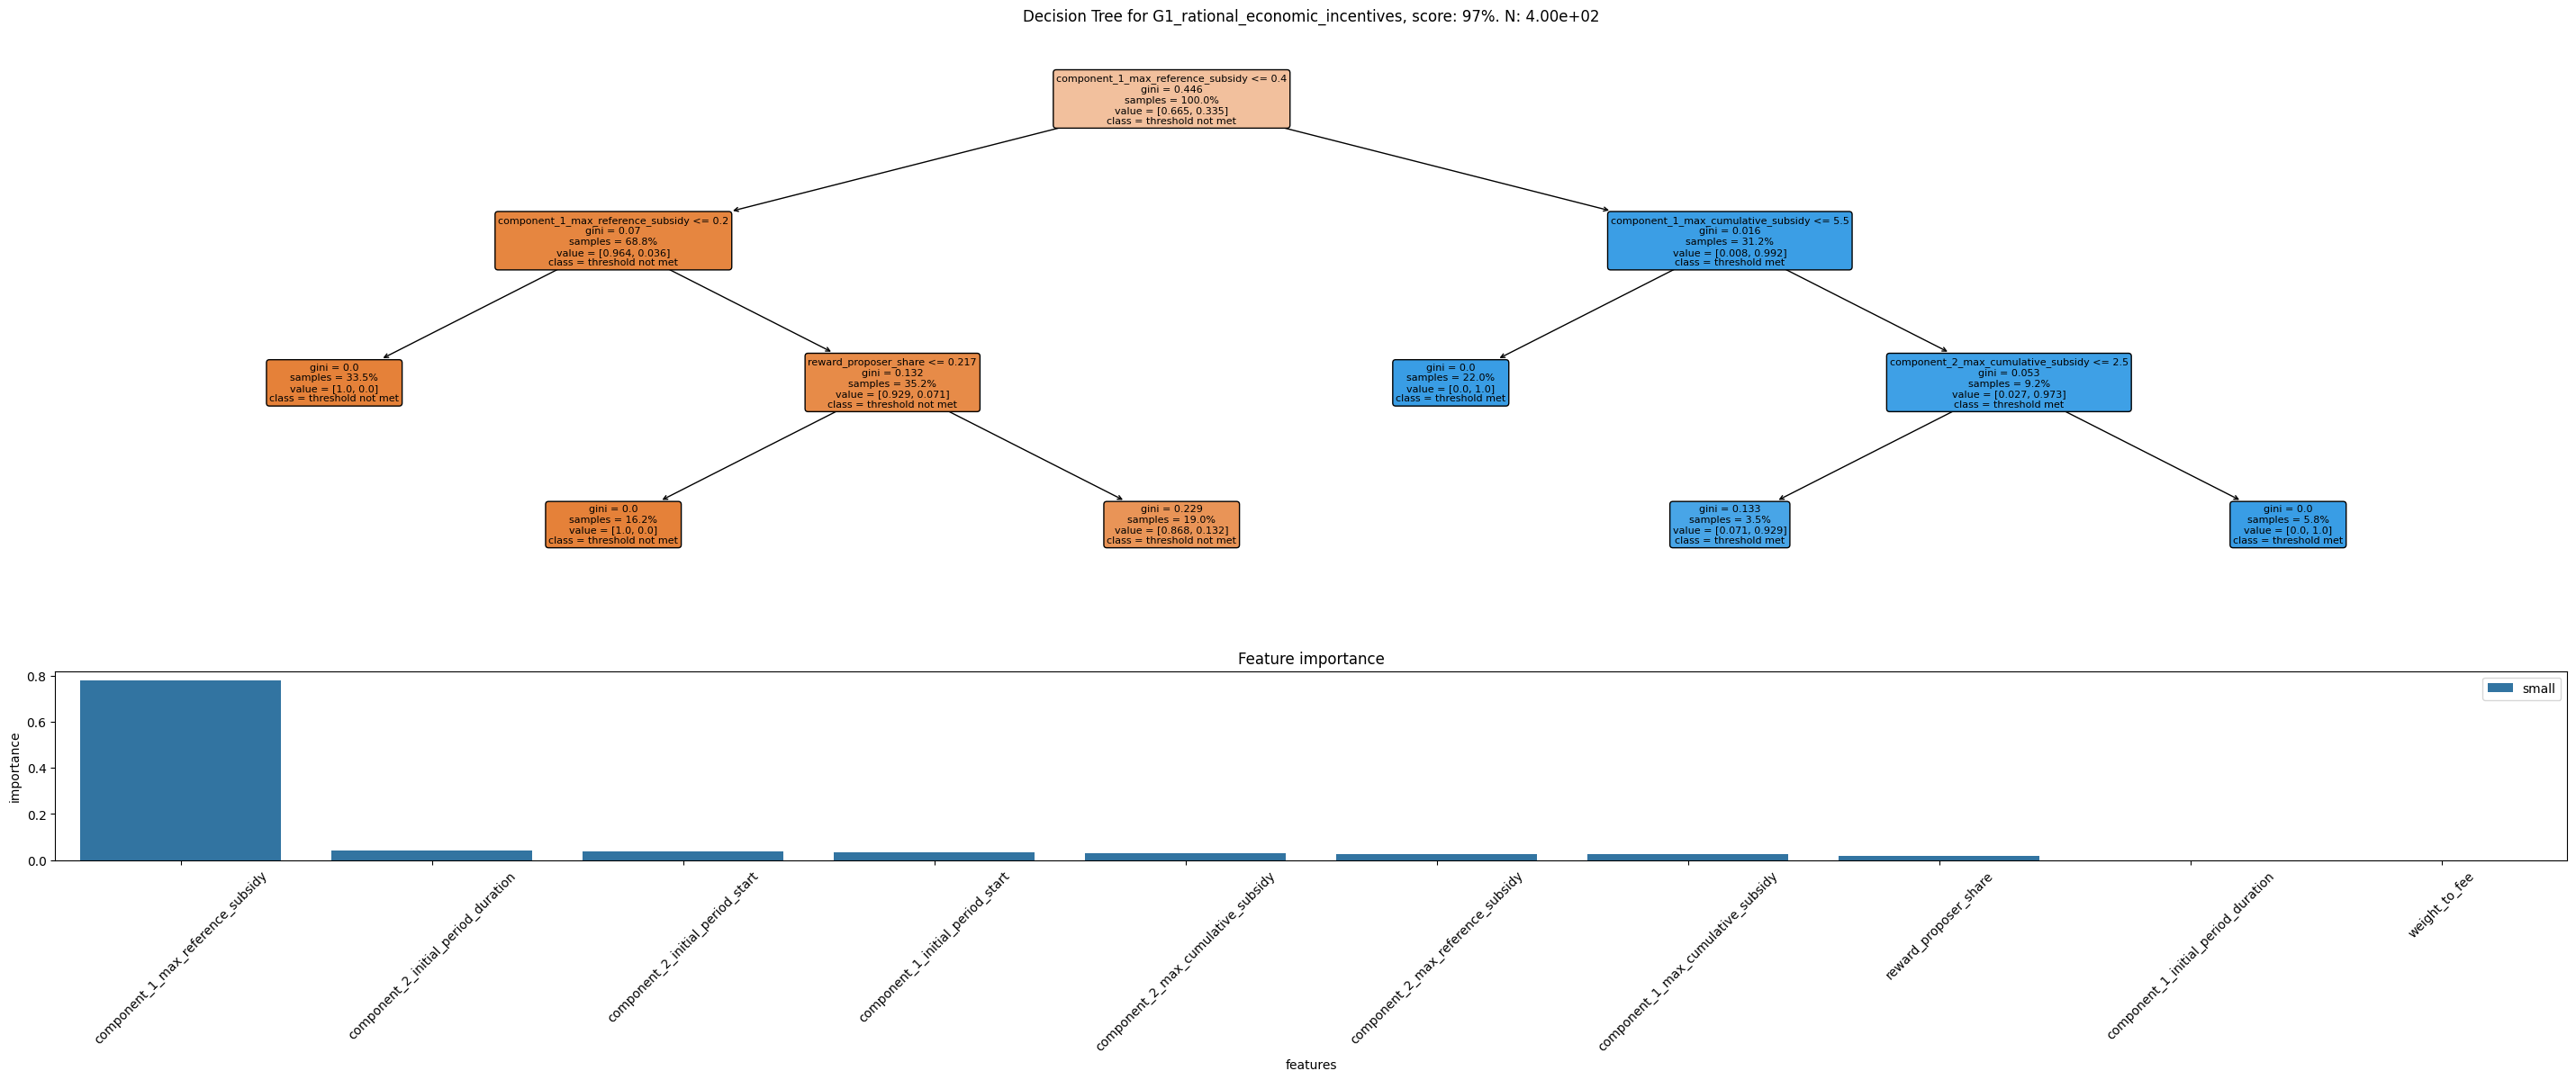

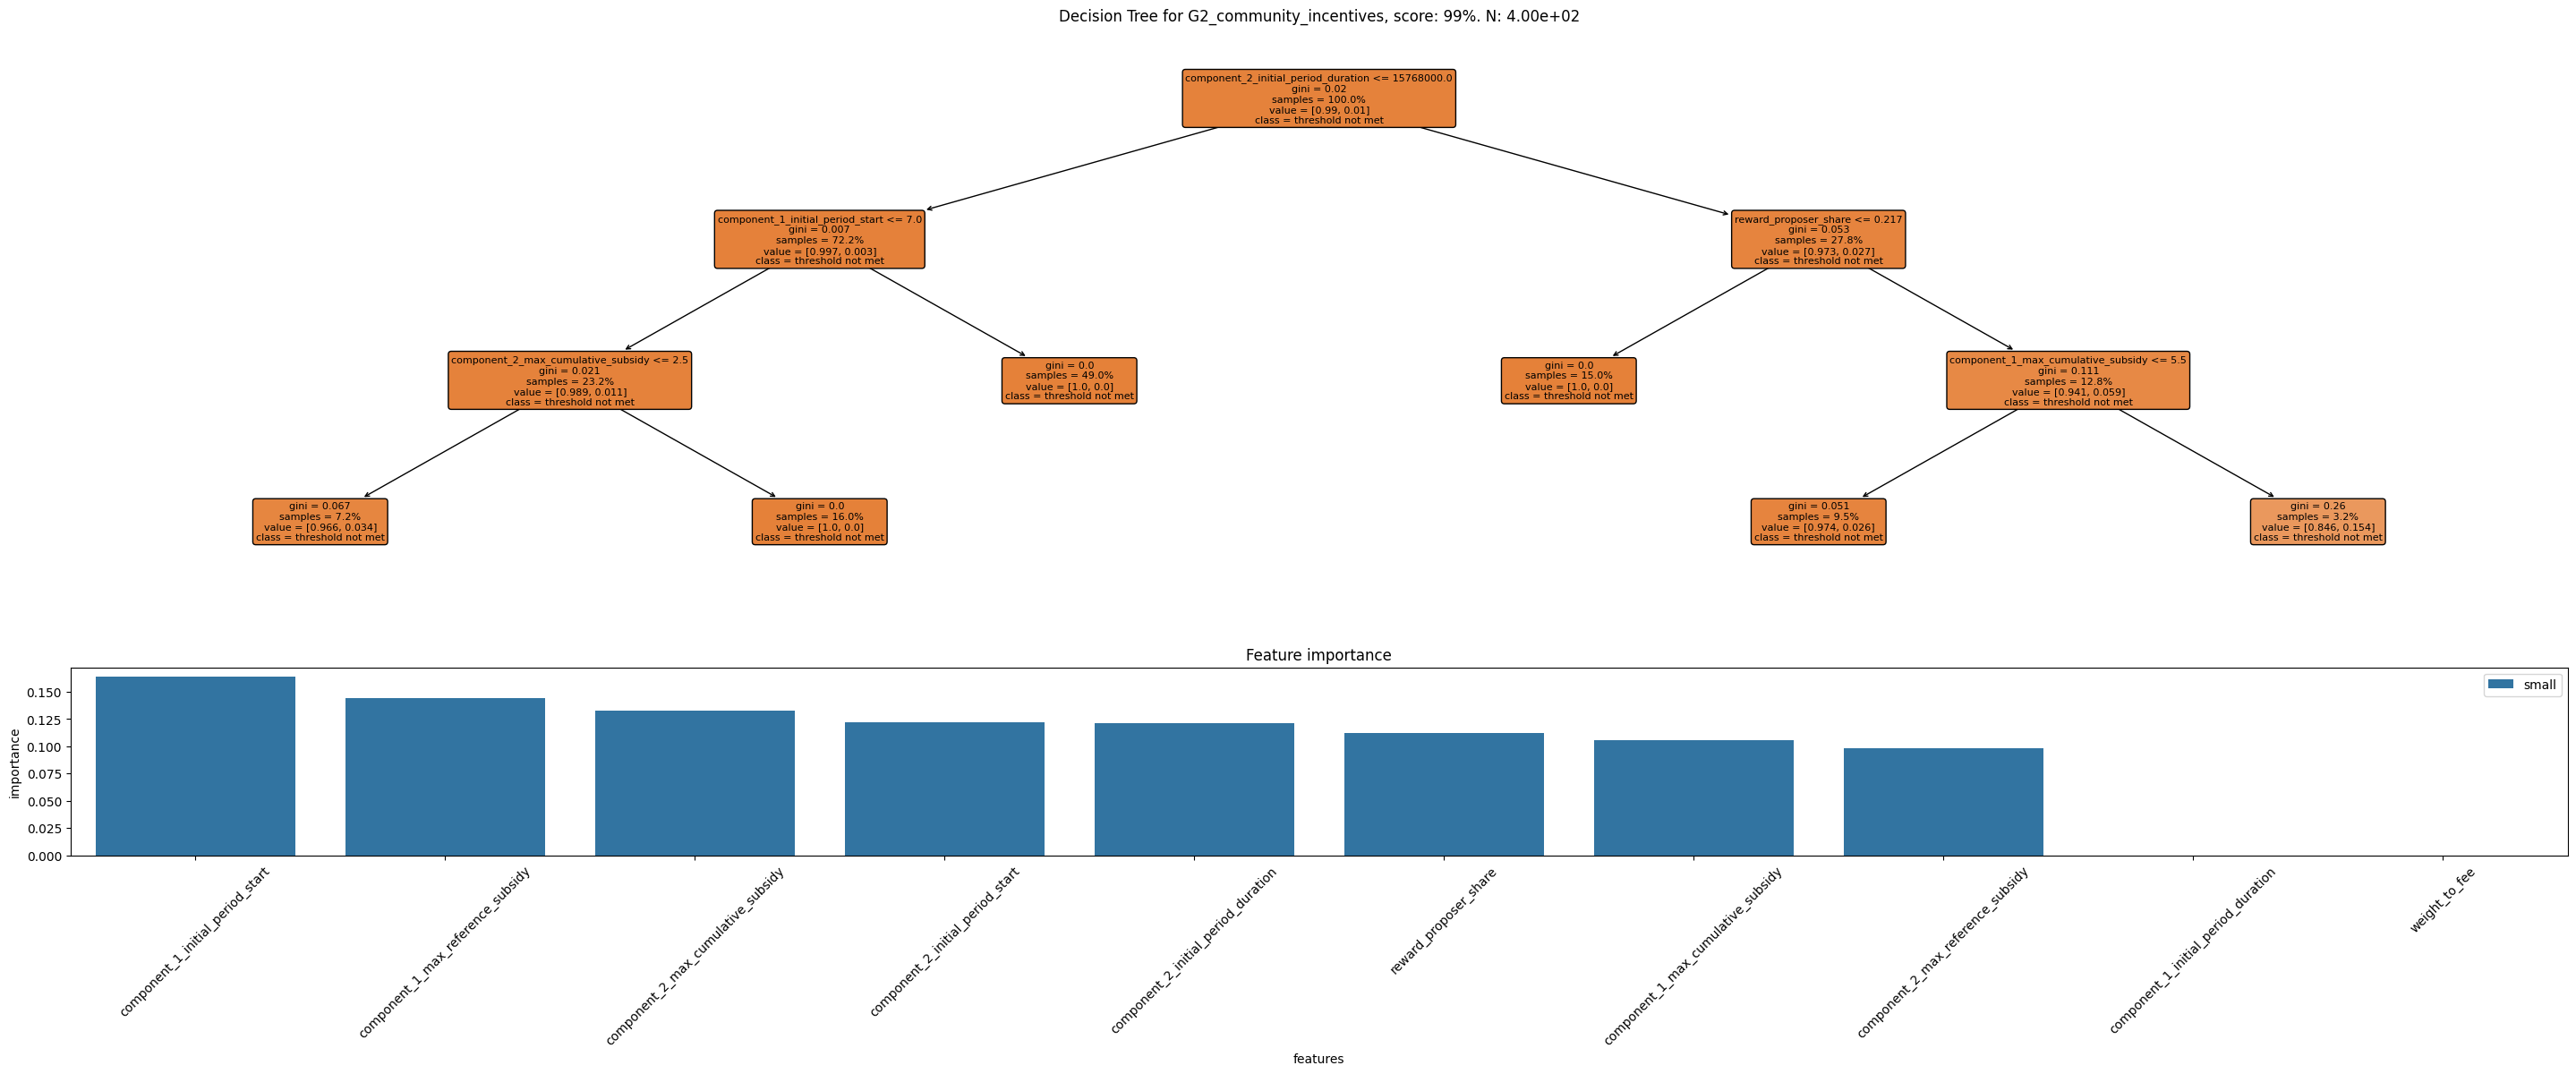

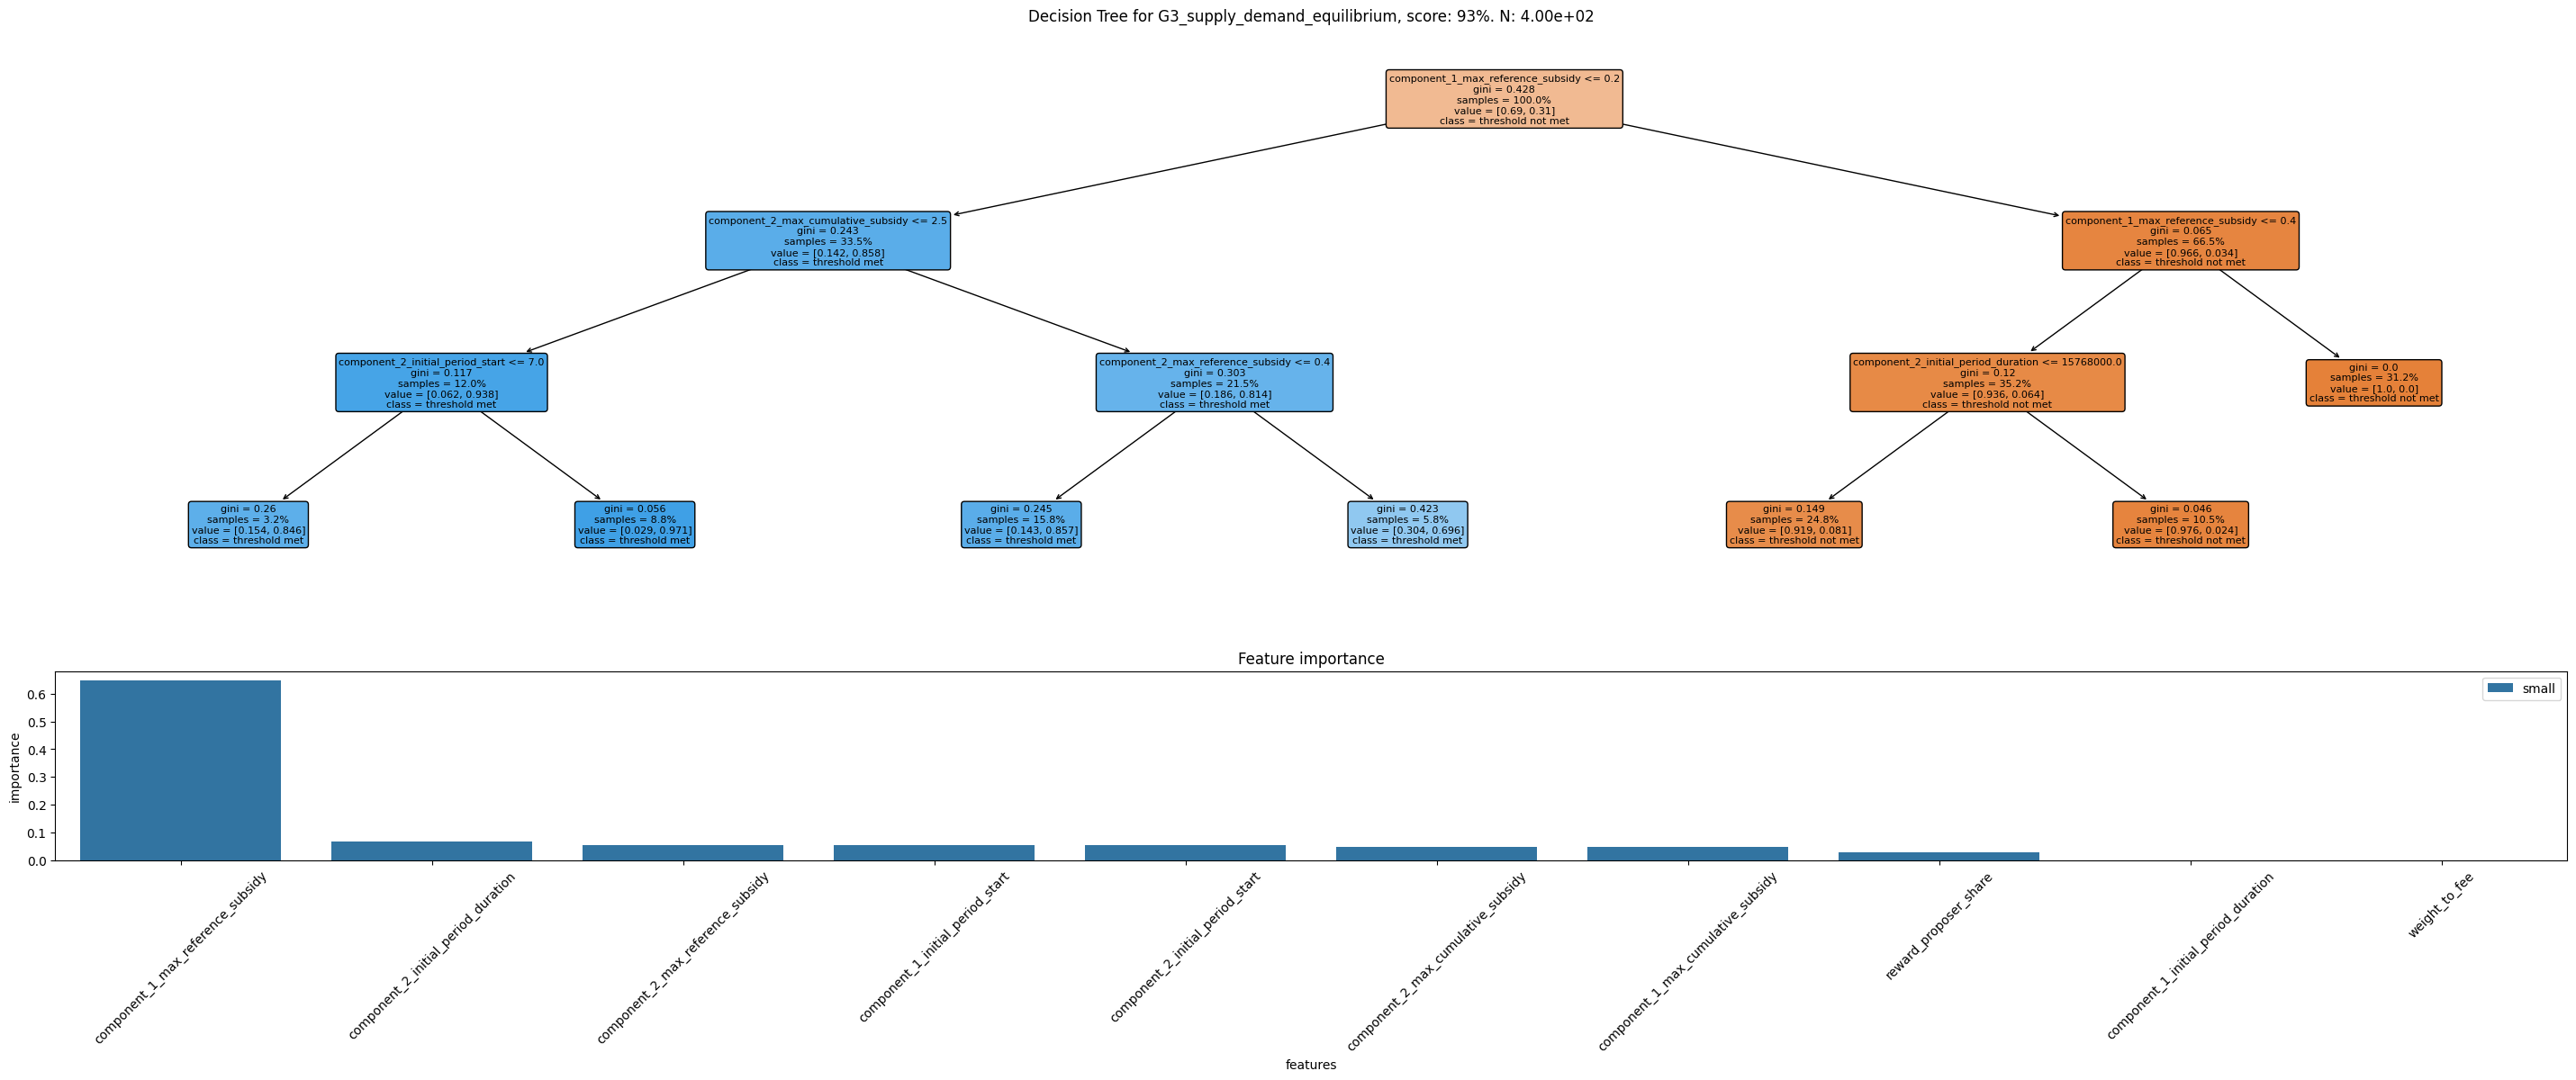

In [7]:
for goal, kpis in GOAL_KPI_GROUPS.items():
    goal_df = calculate_goal_score(agg_df, goal, goal)
    create_decision_tree_importances_plot(goal_df, goal, success_criteria='larger_than_median')


### Parameter Effect into KPIs

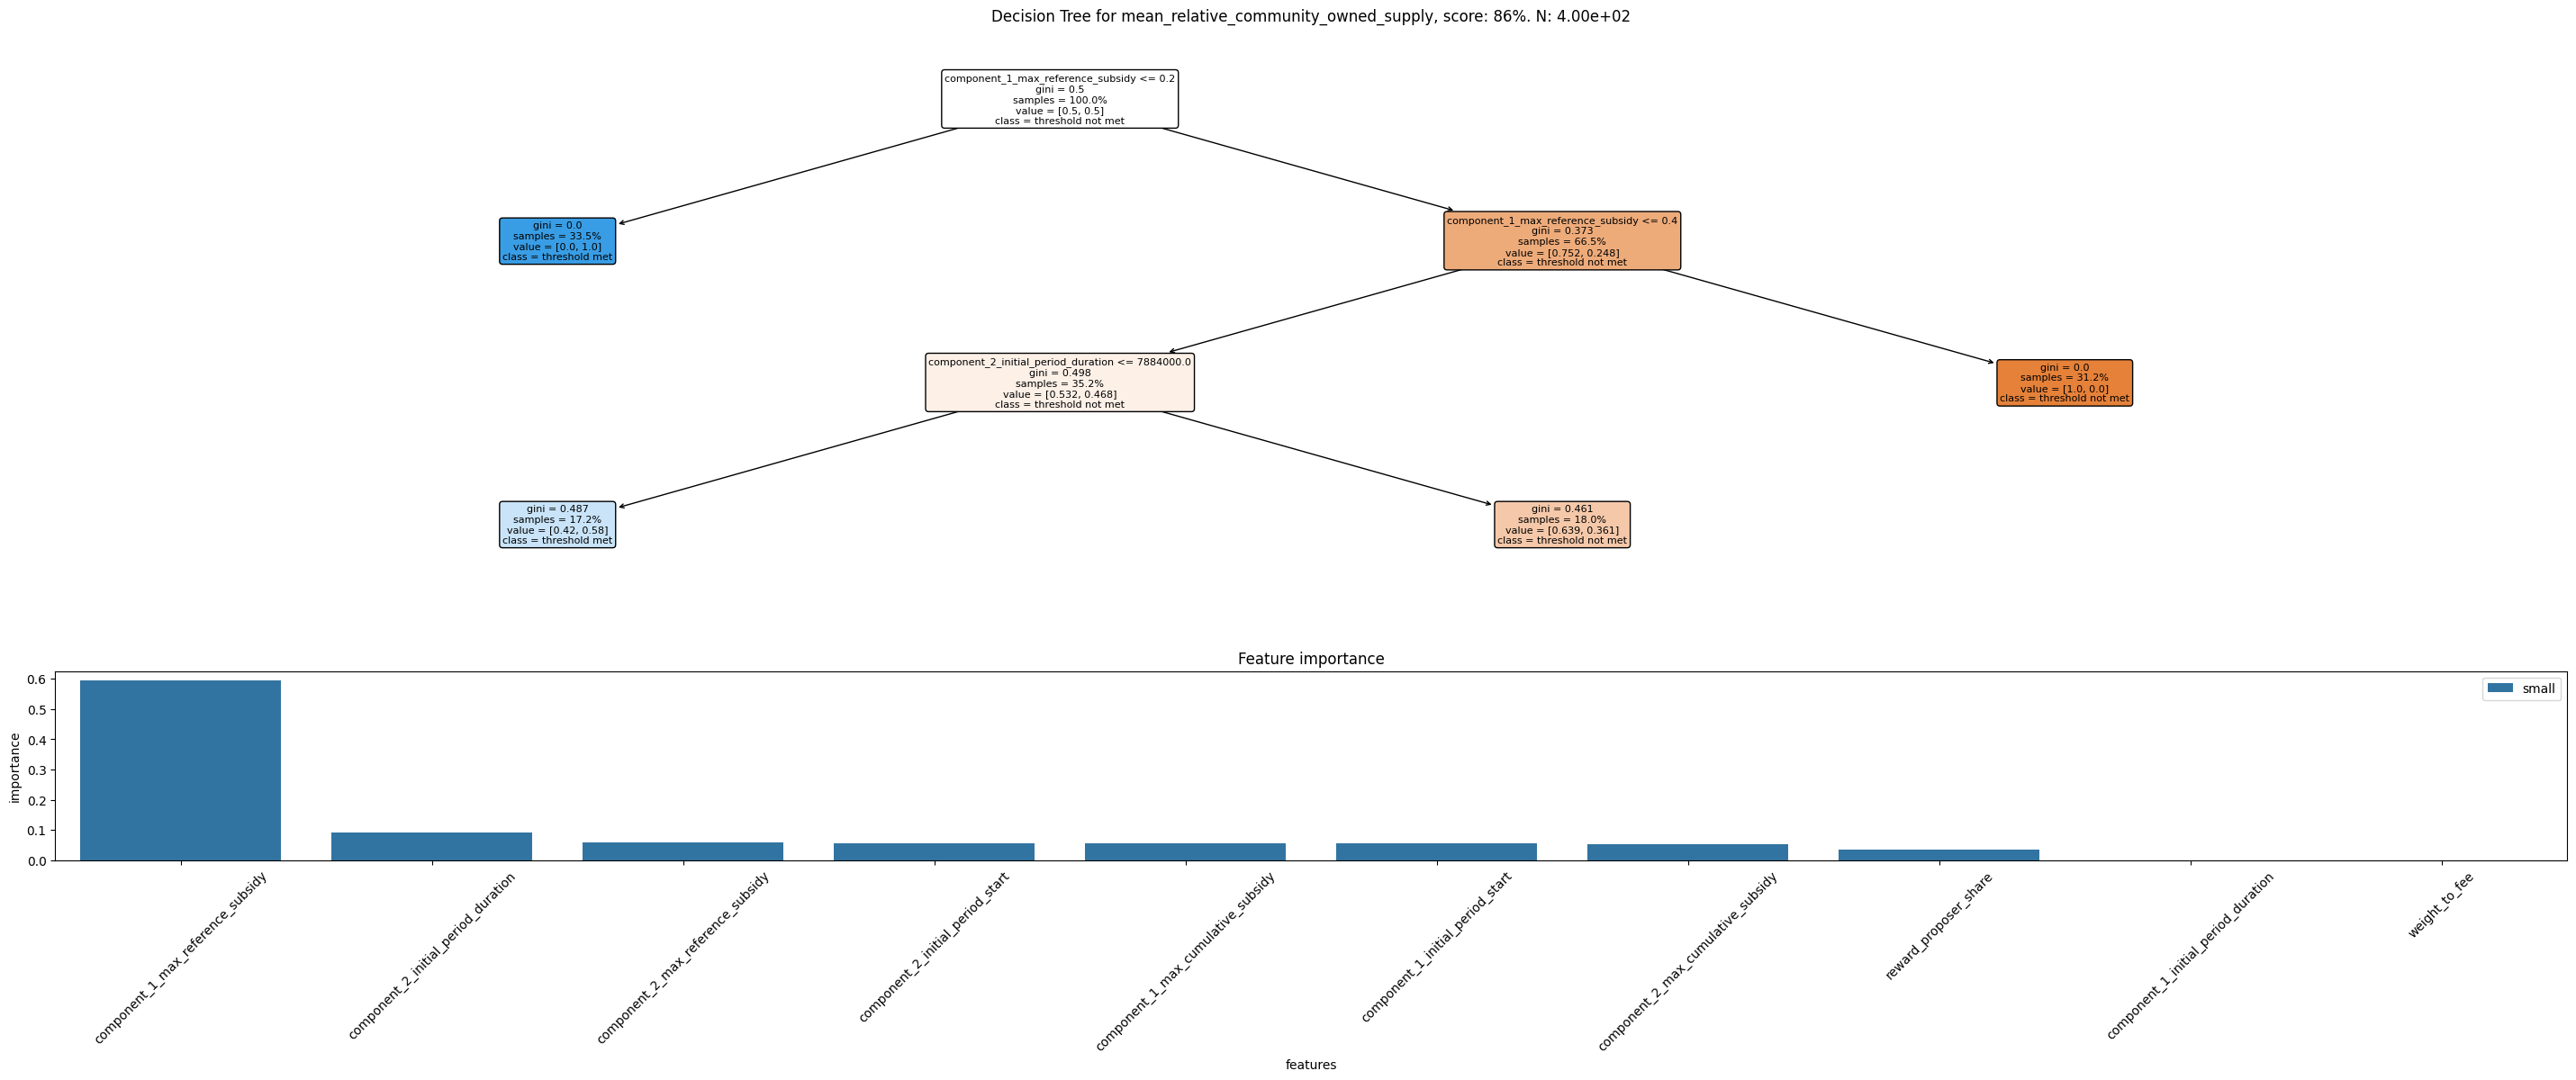

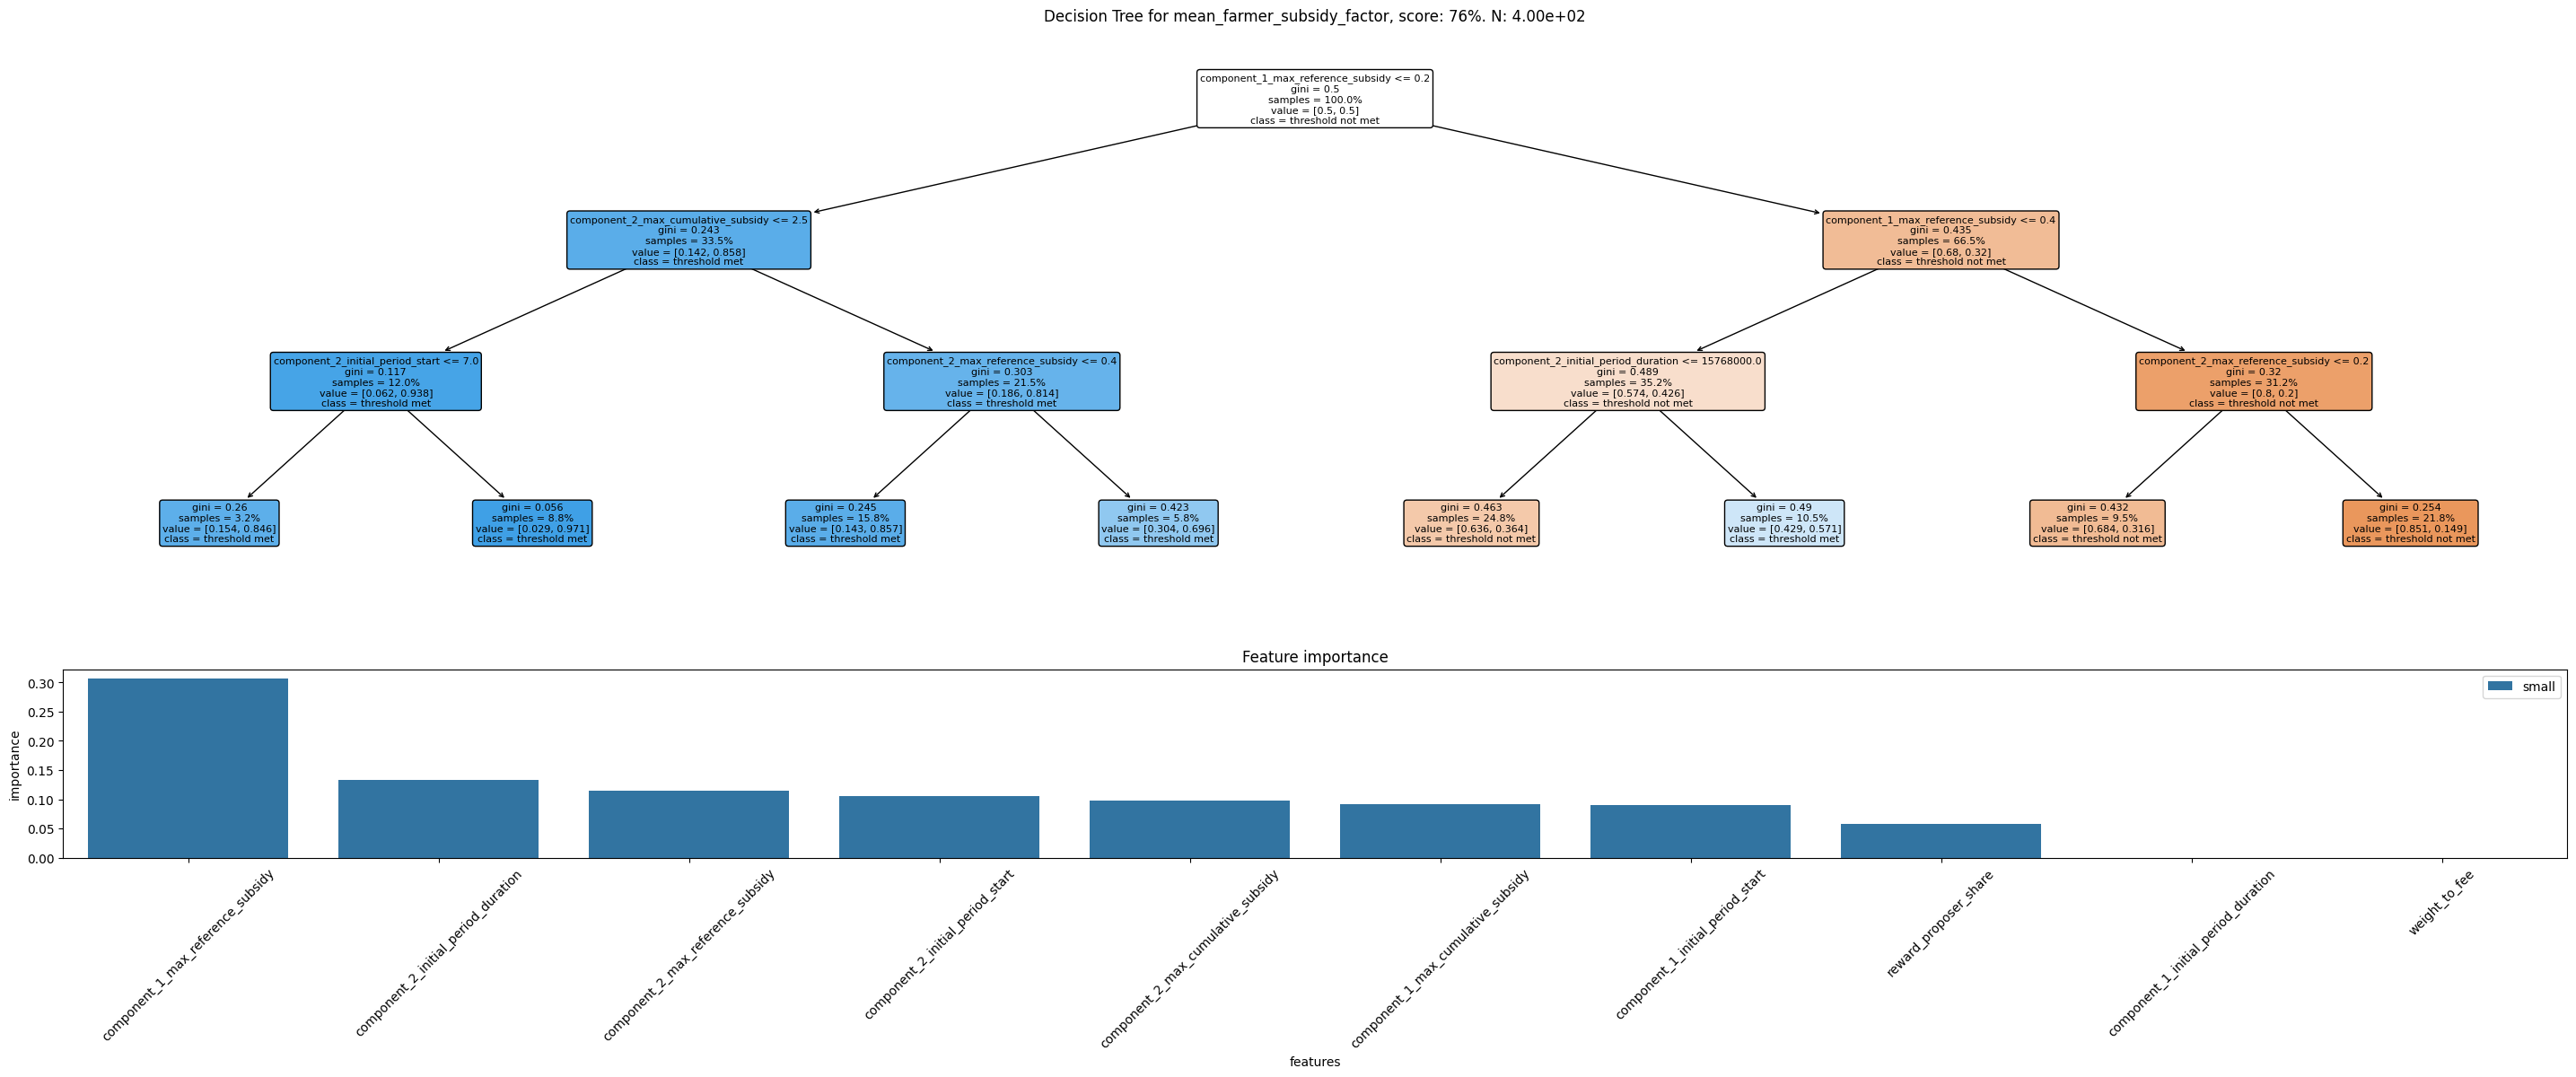

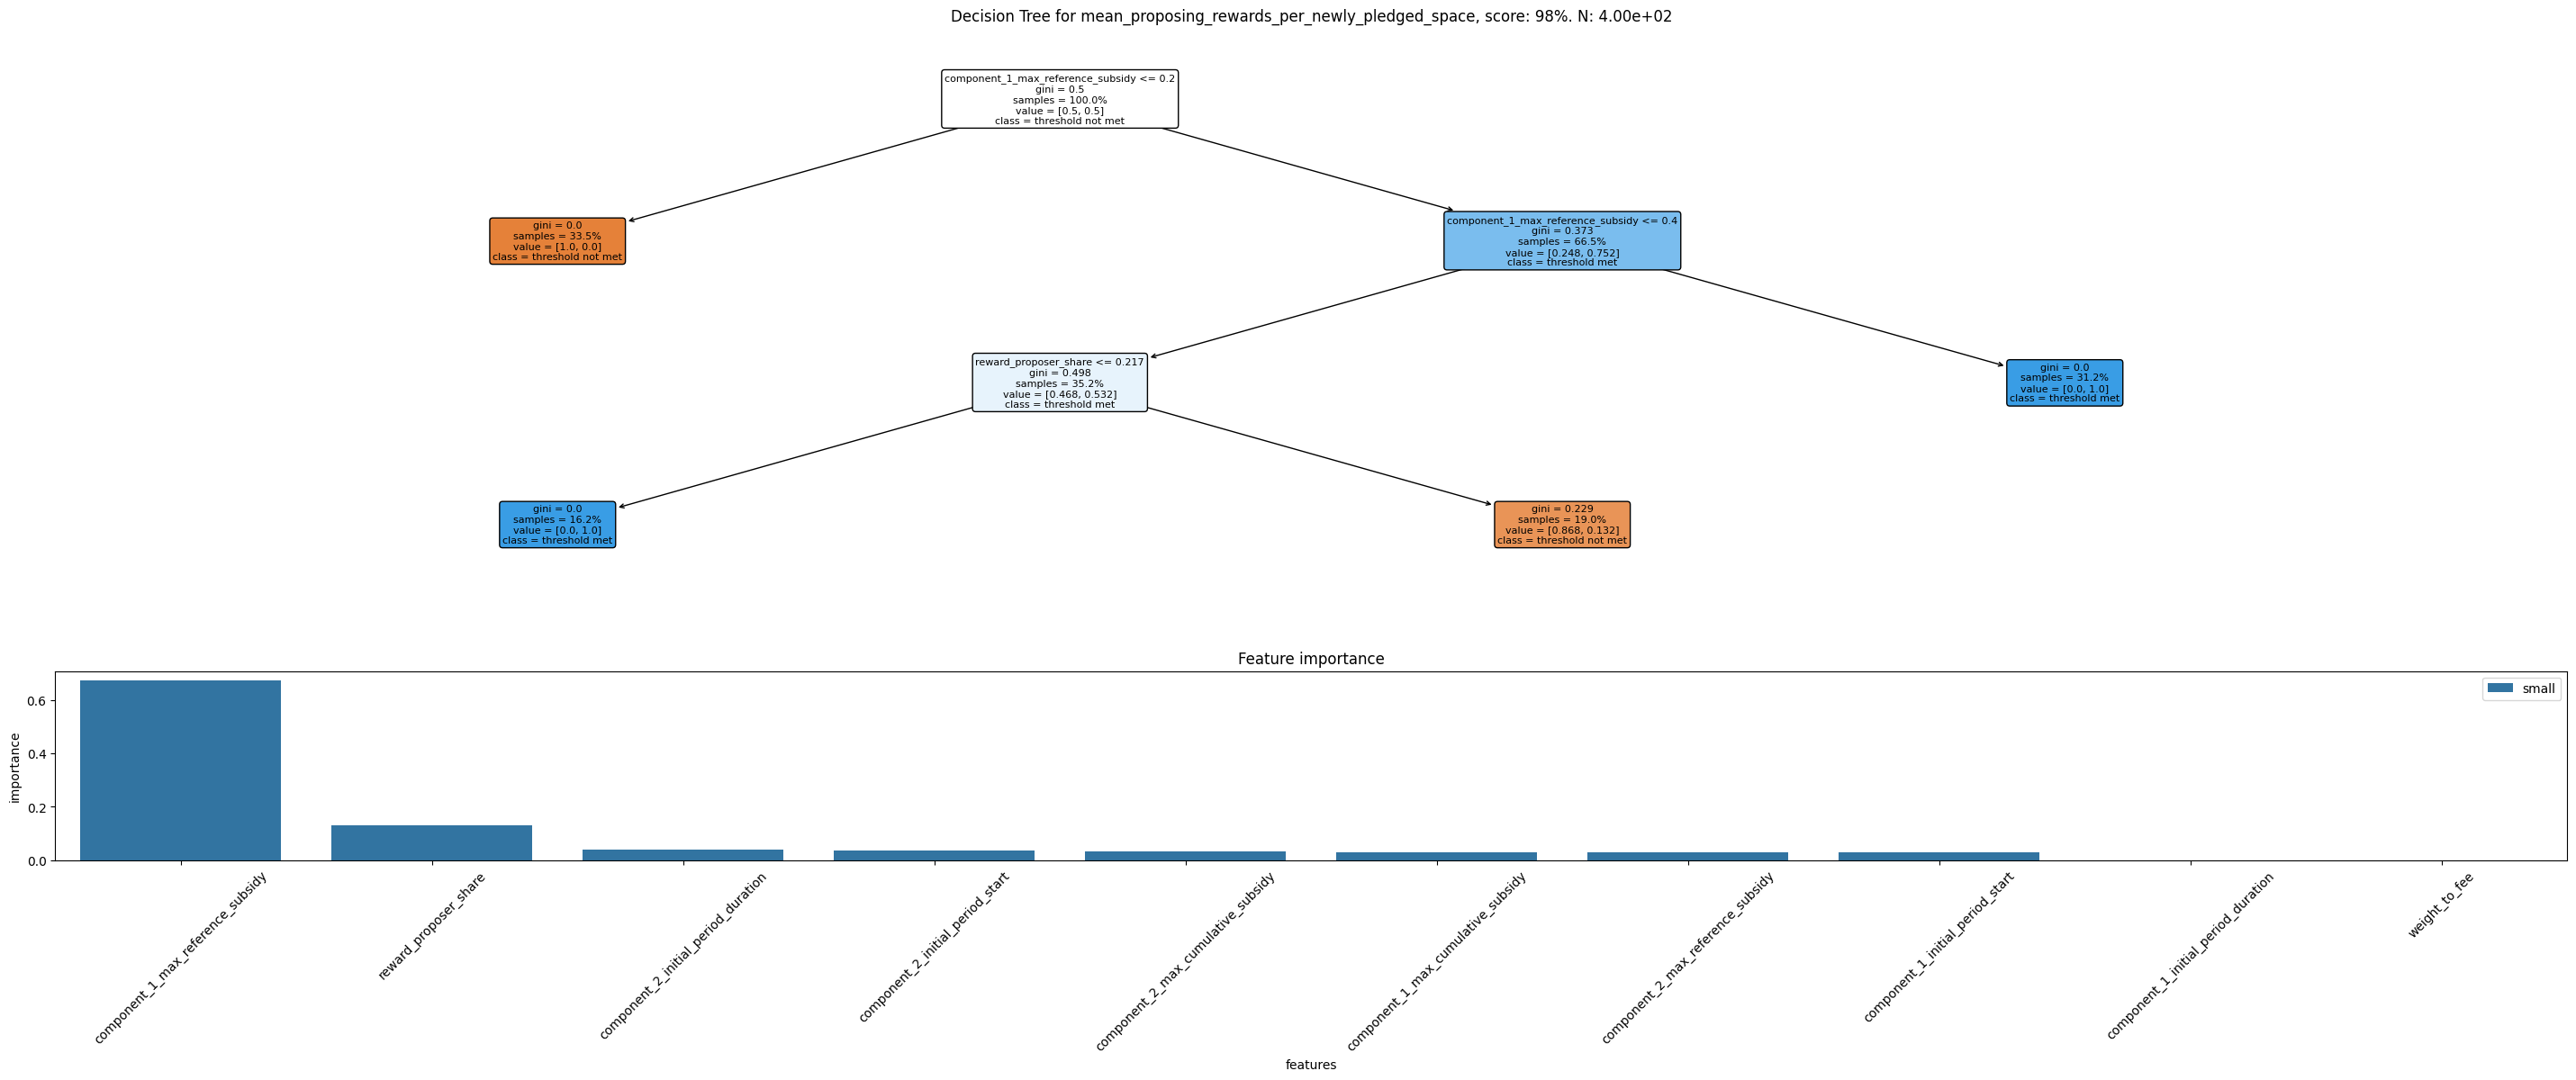

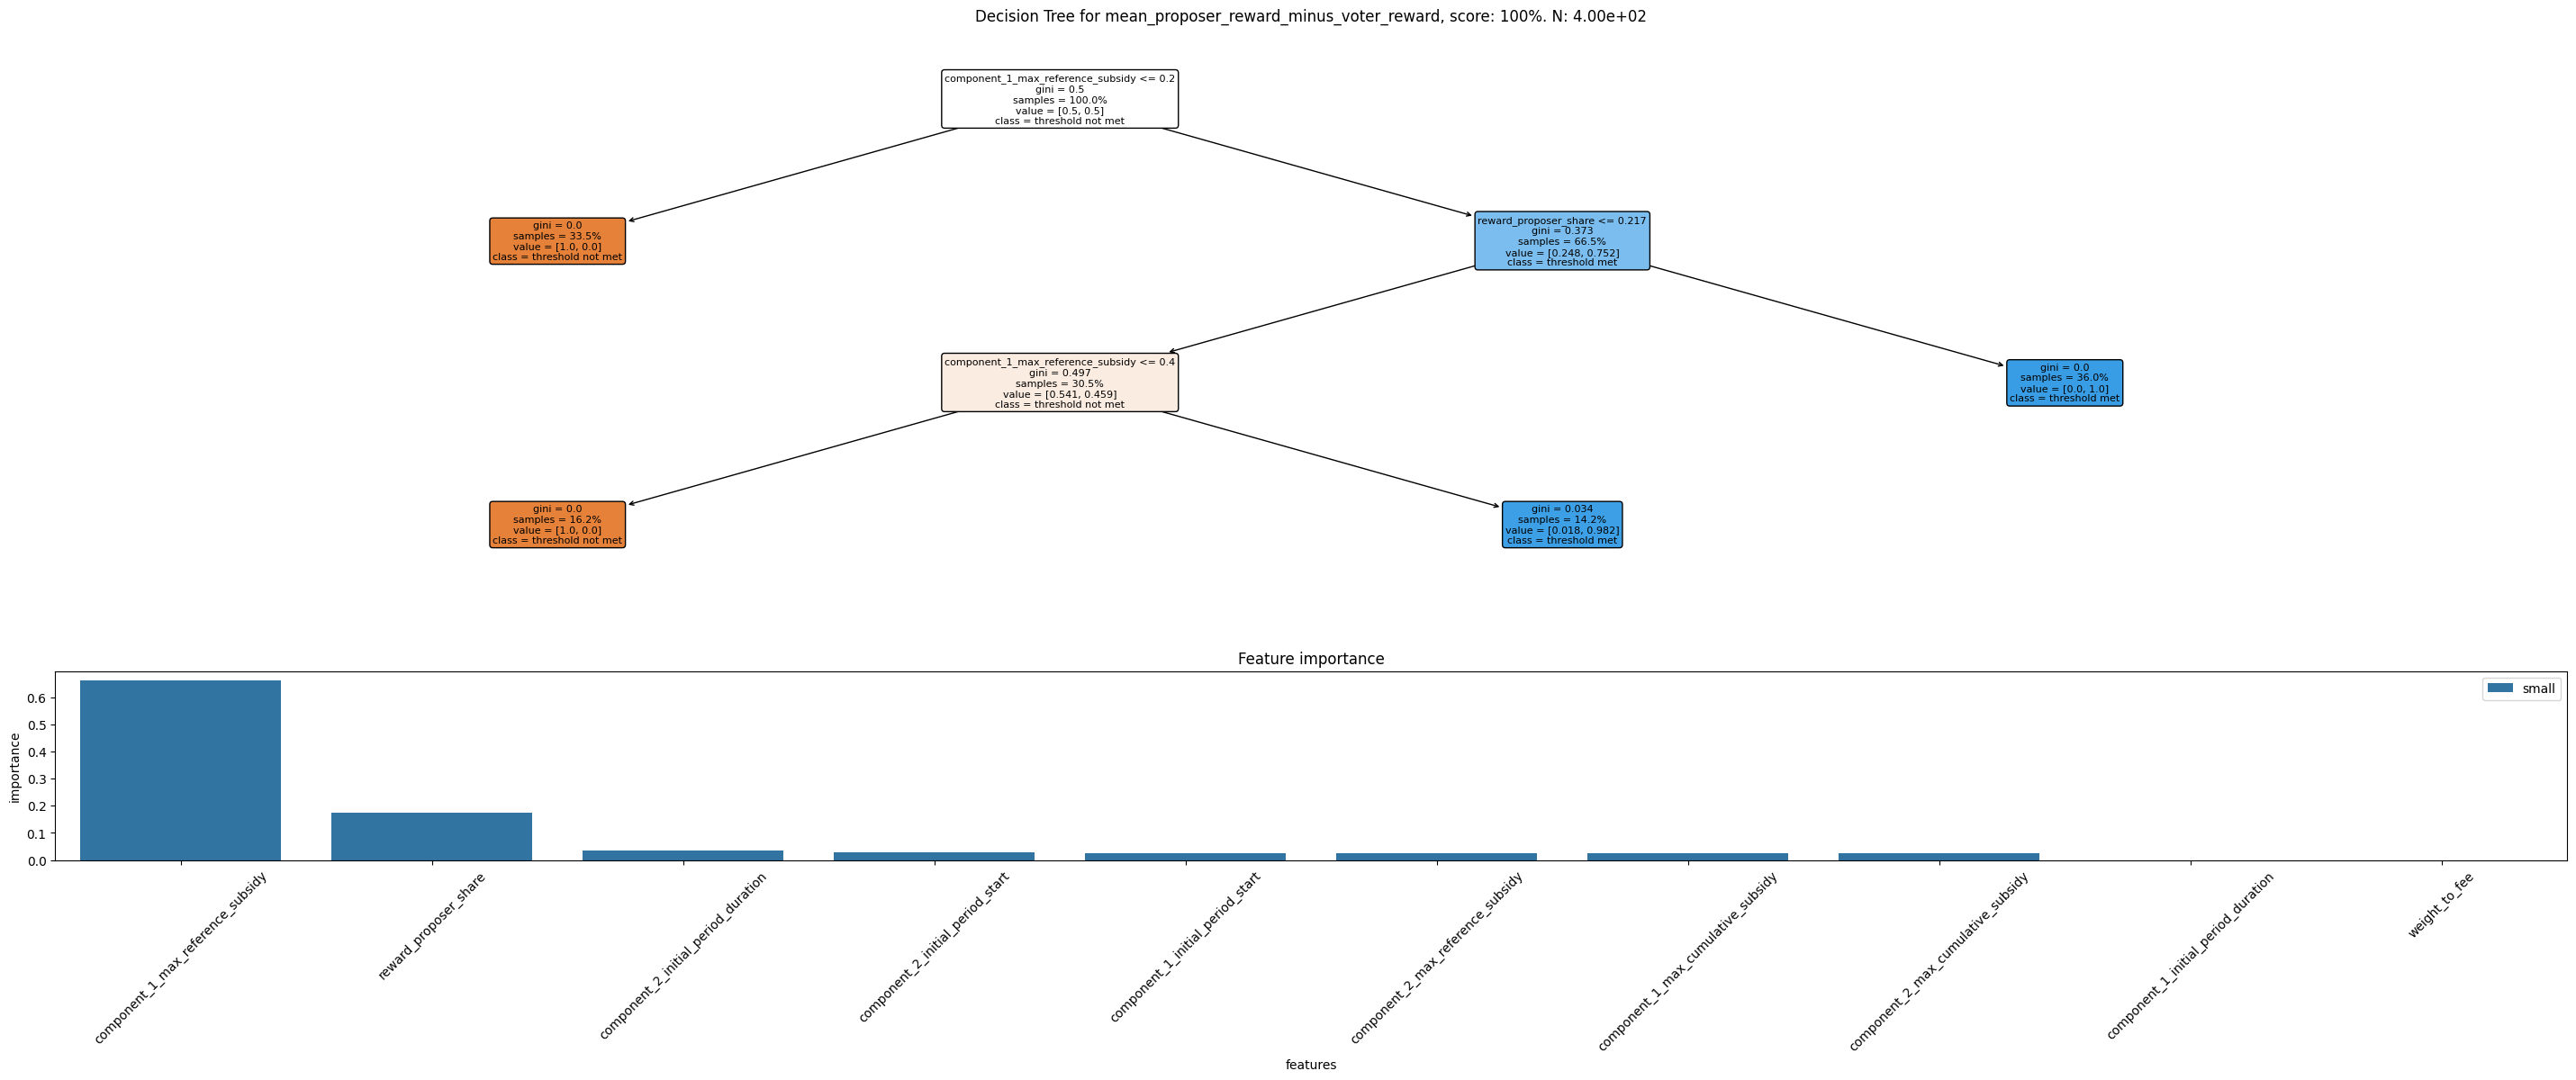

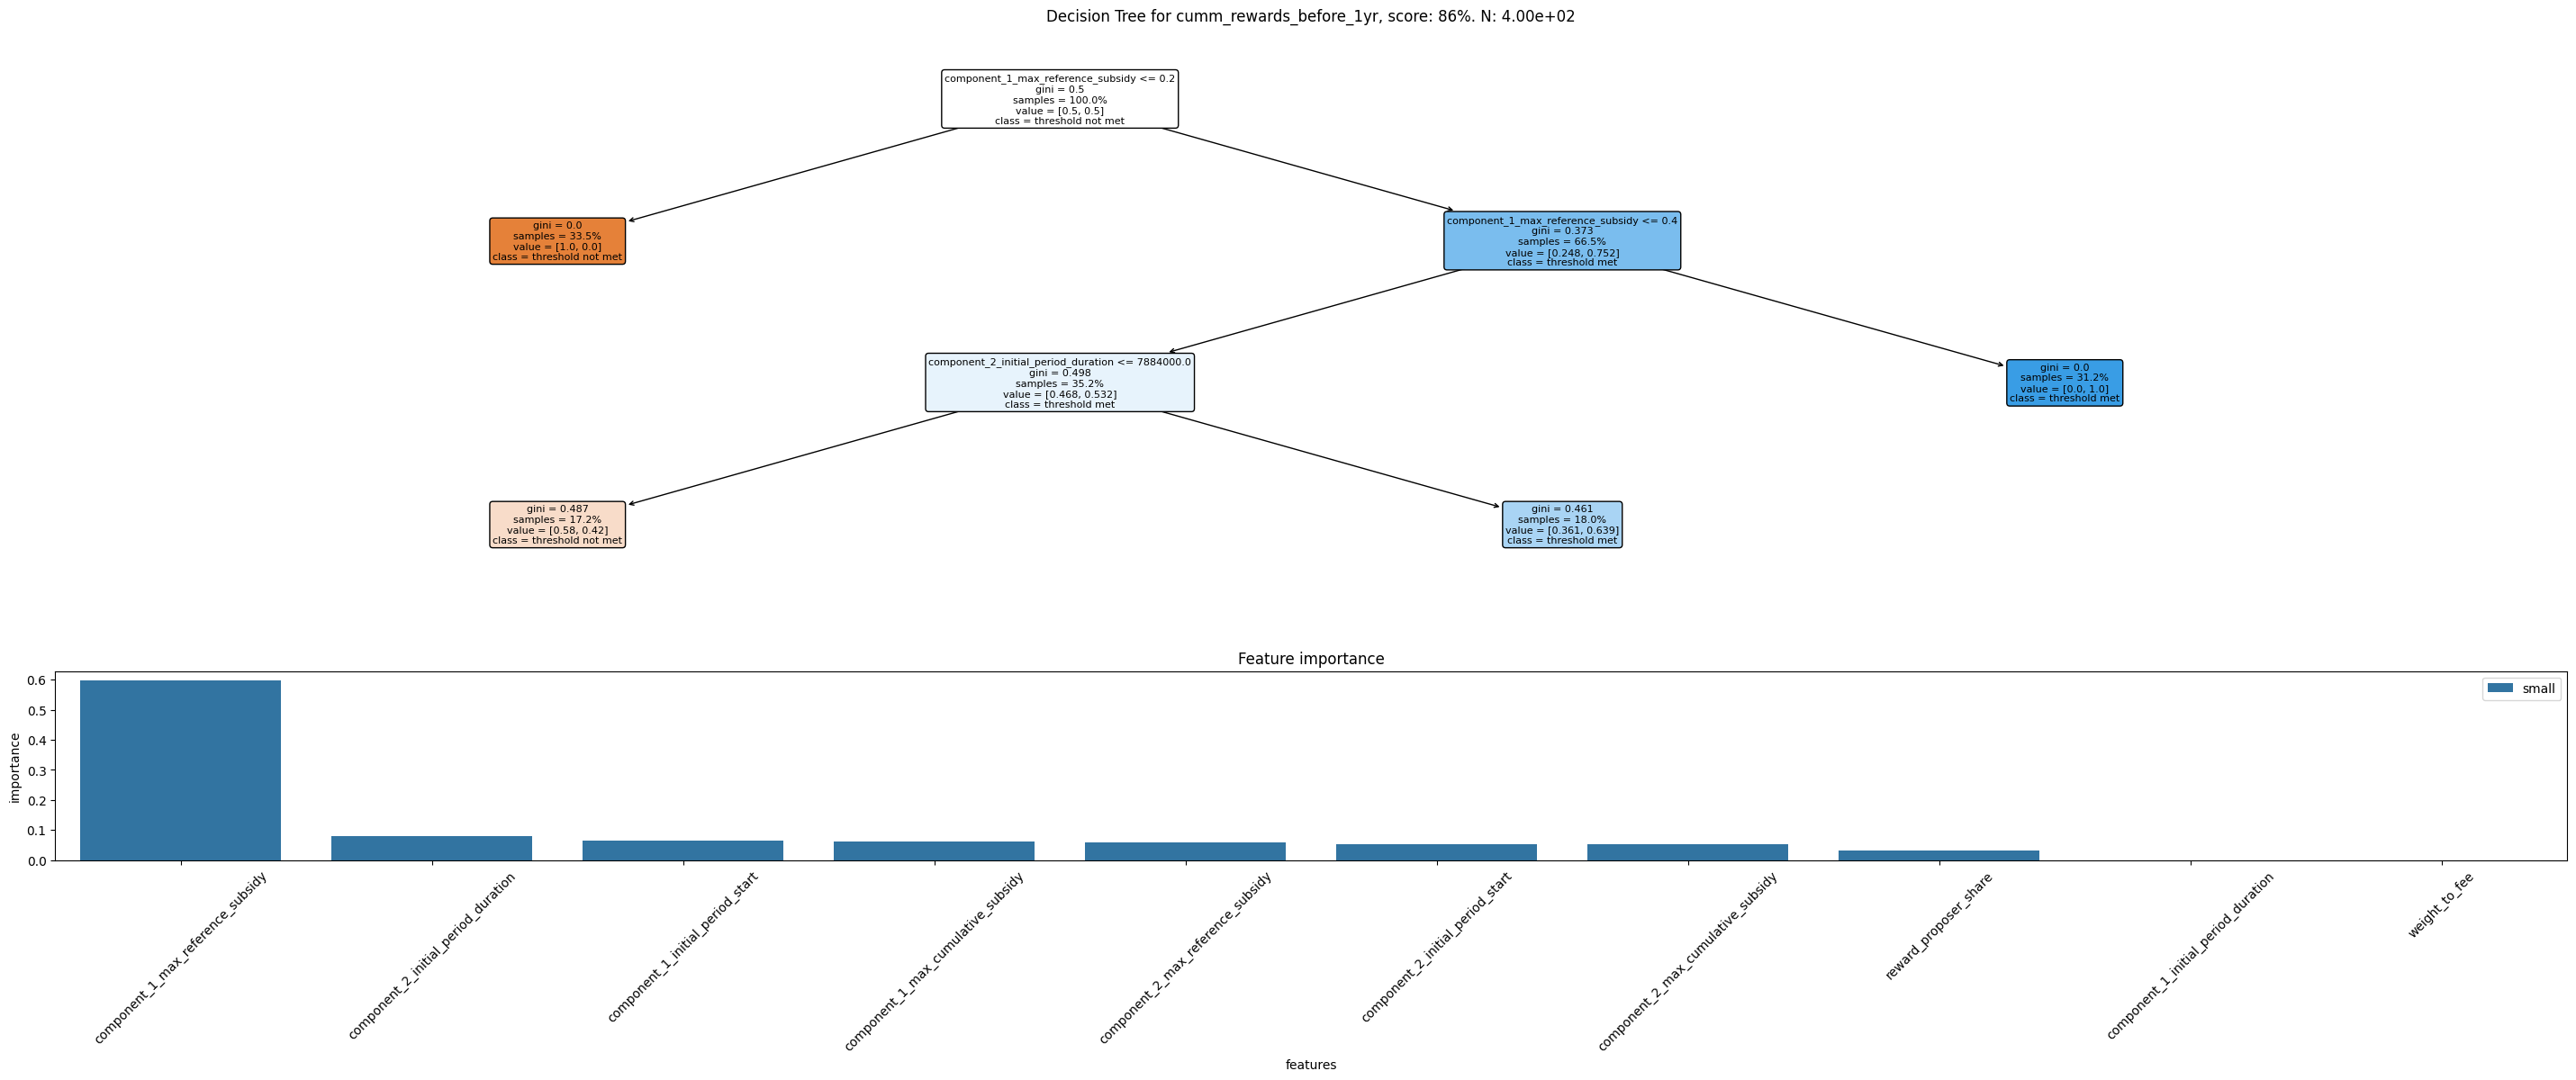

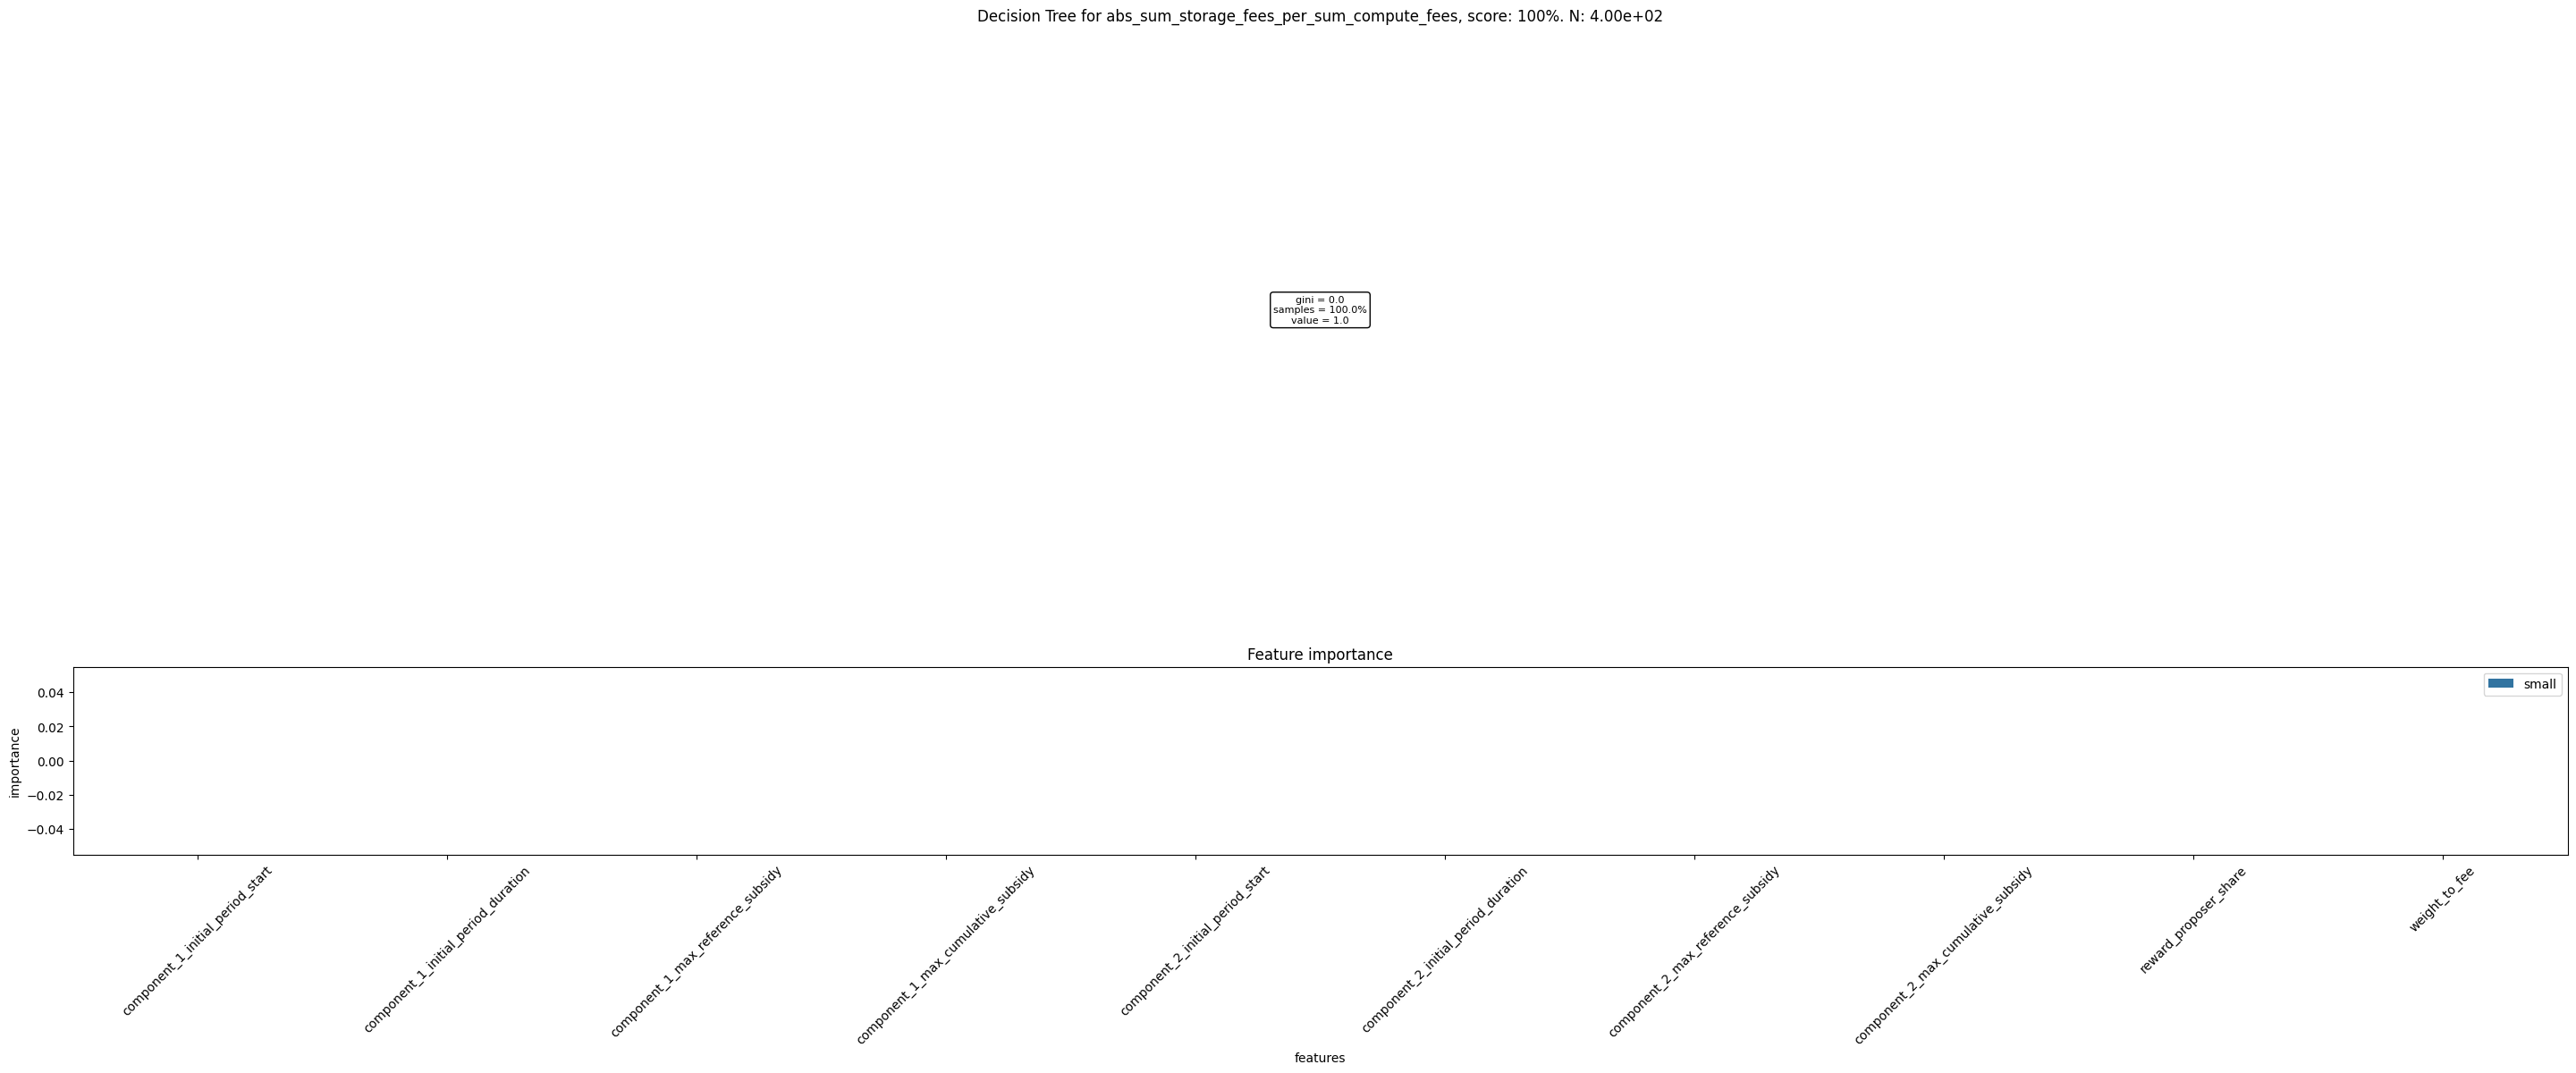

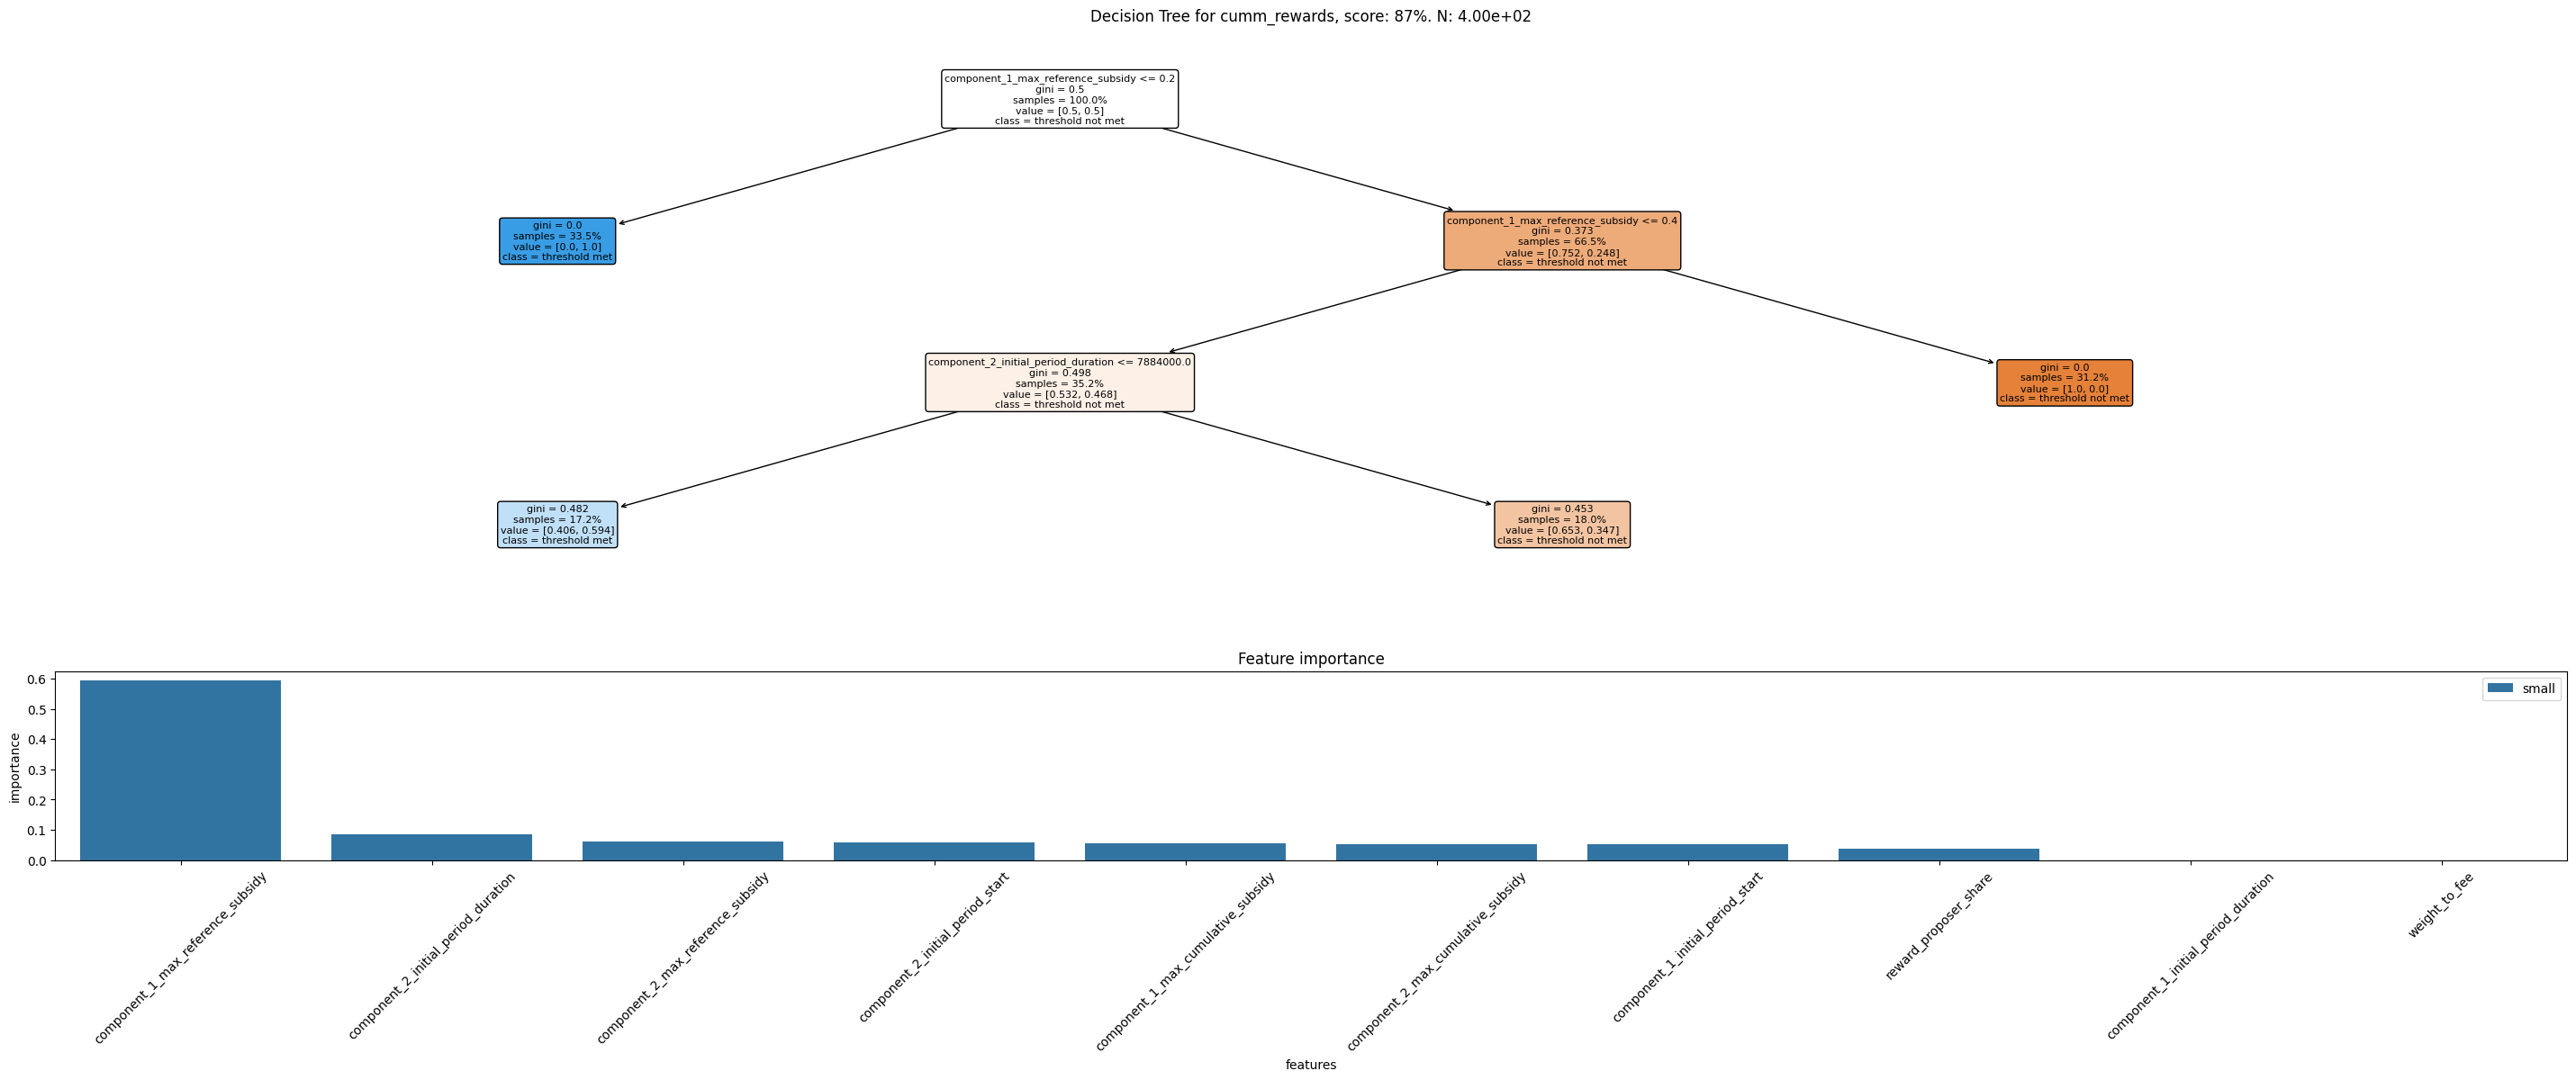

In [8]:
for col_name, (kpi_f, kpi_t) in KPI_functions.items():
    create_decision_tree_importances_plot(agg_df,
                                        col_name =col_name,
                                        success_criteria=kpi_t)
    plt.show()

### Auxiliary Visualizations

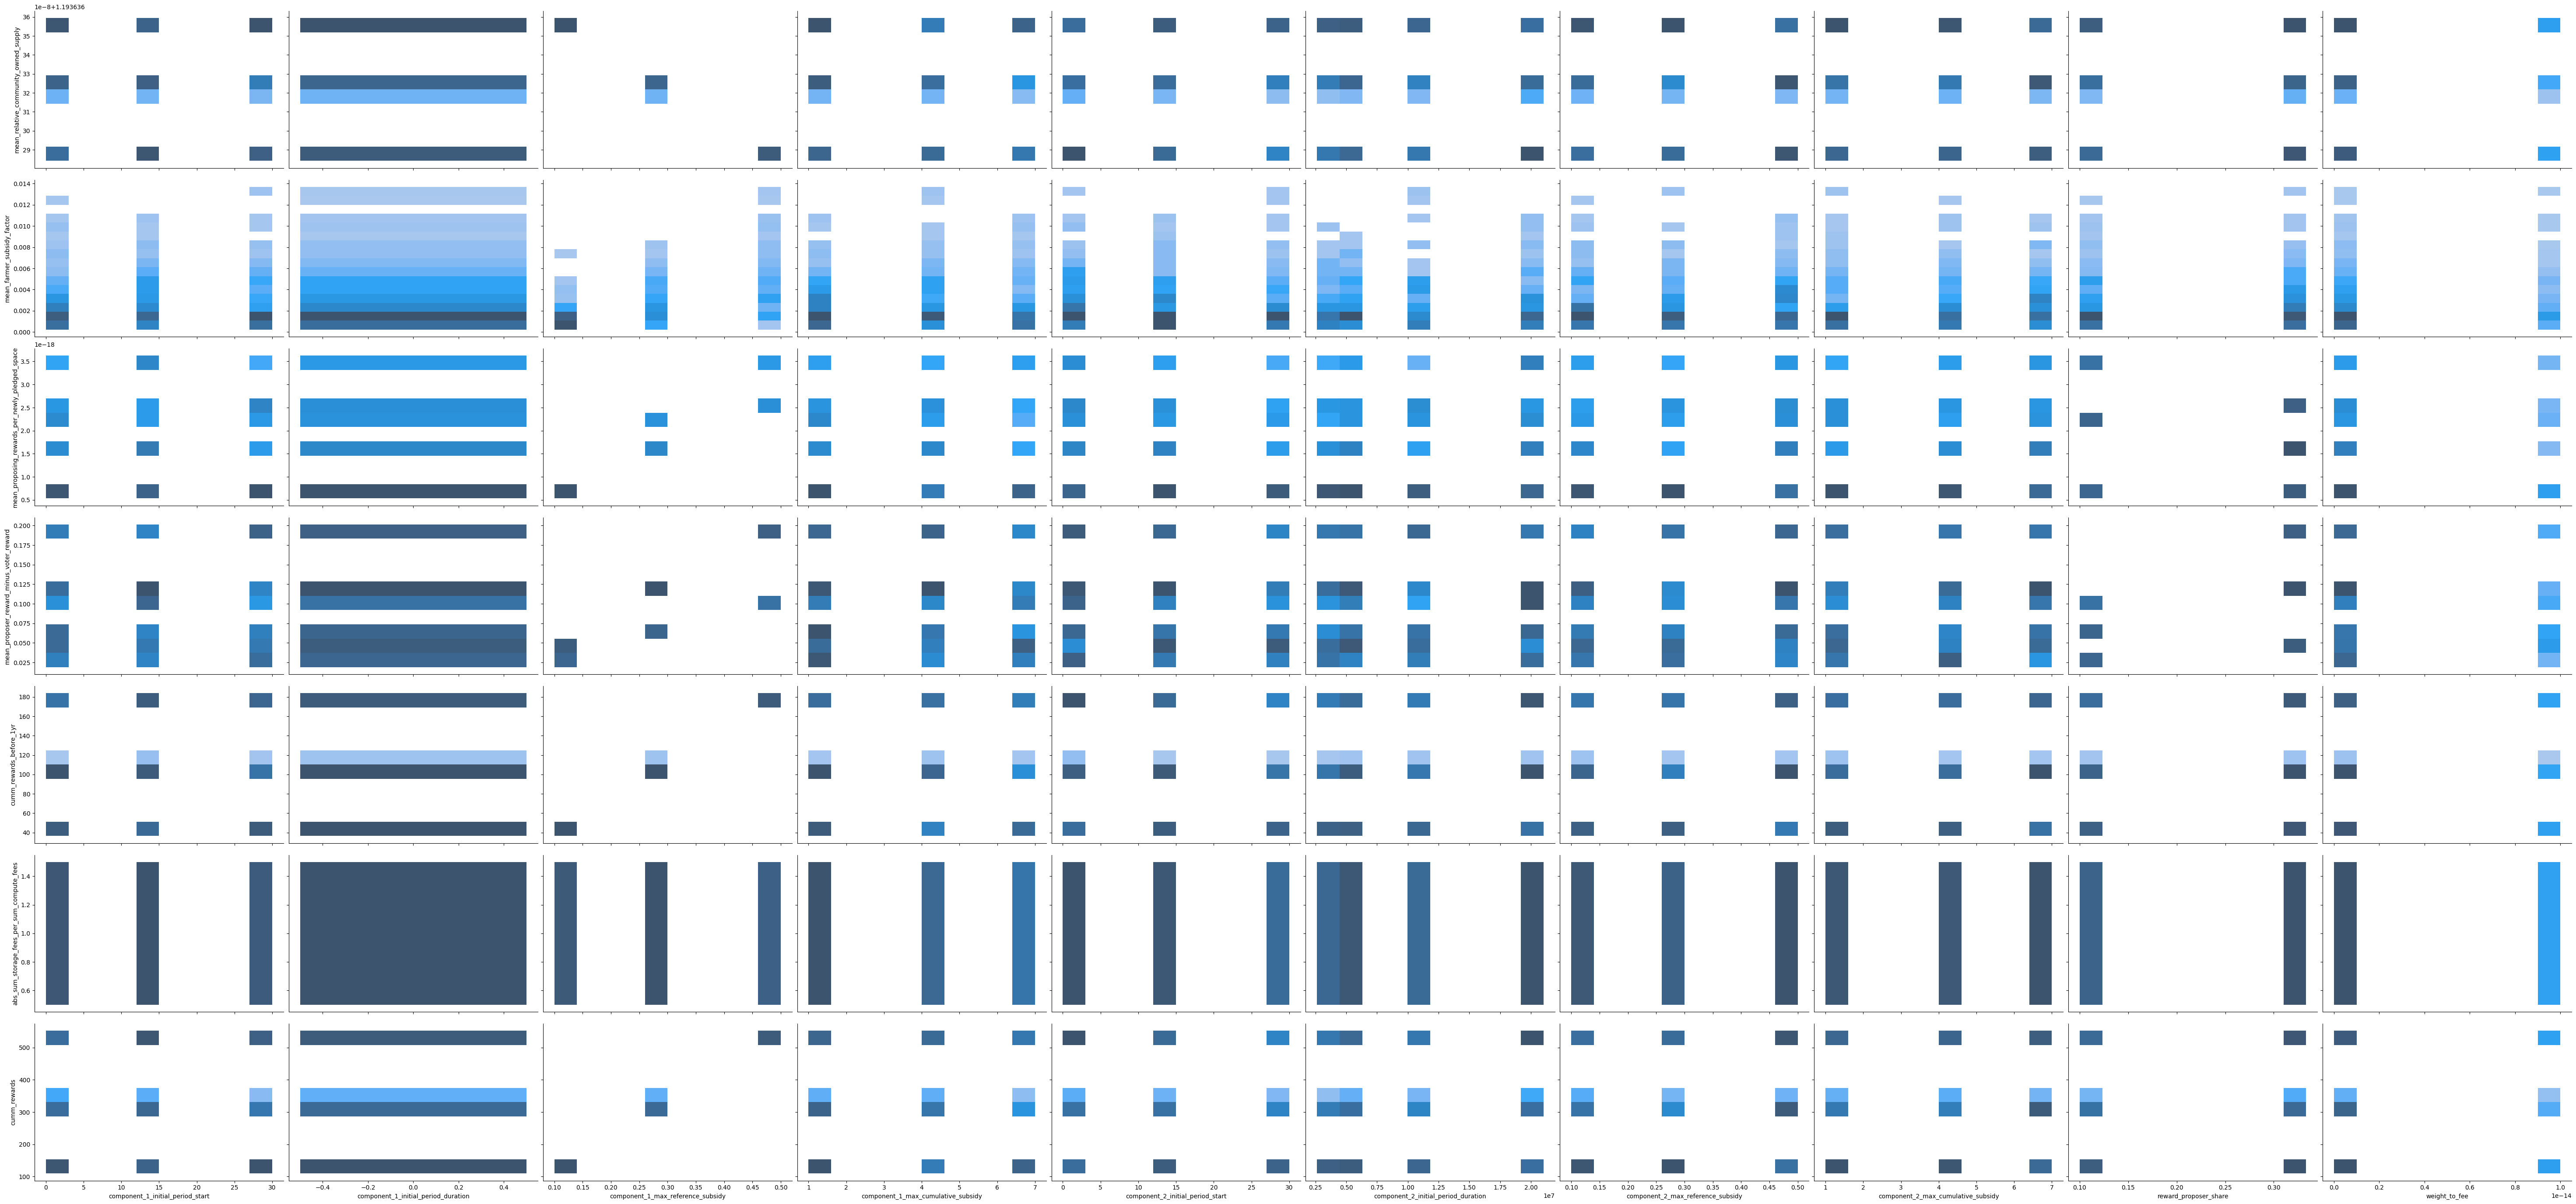

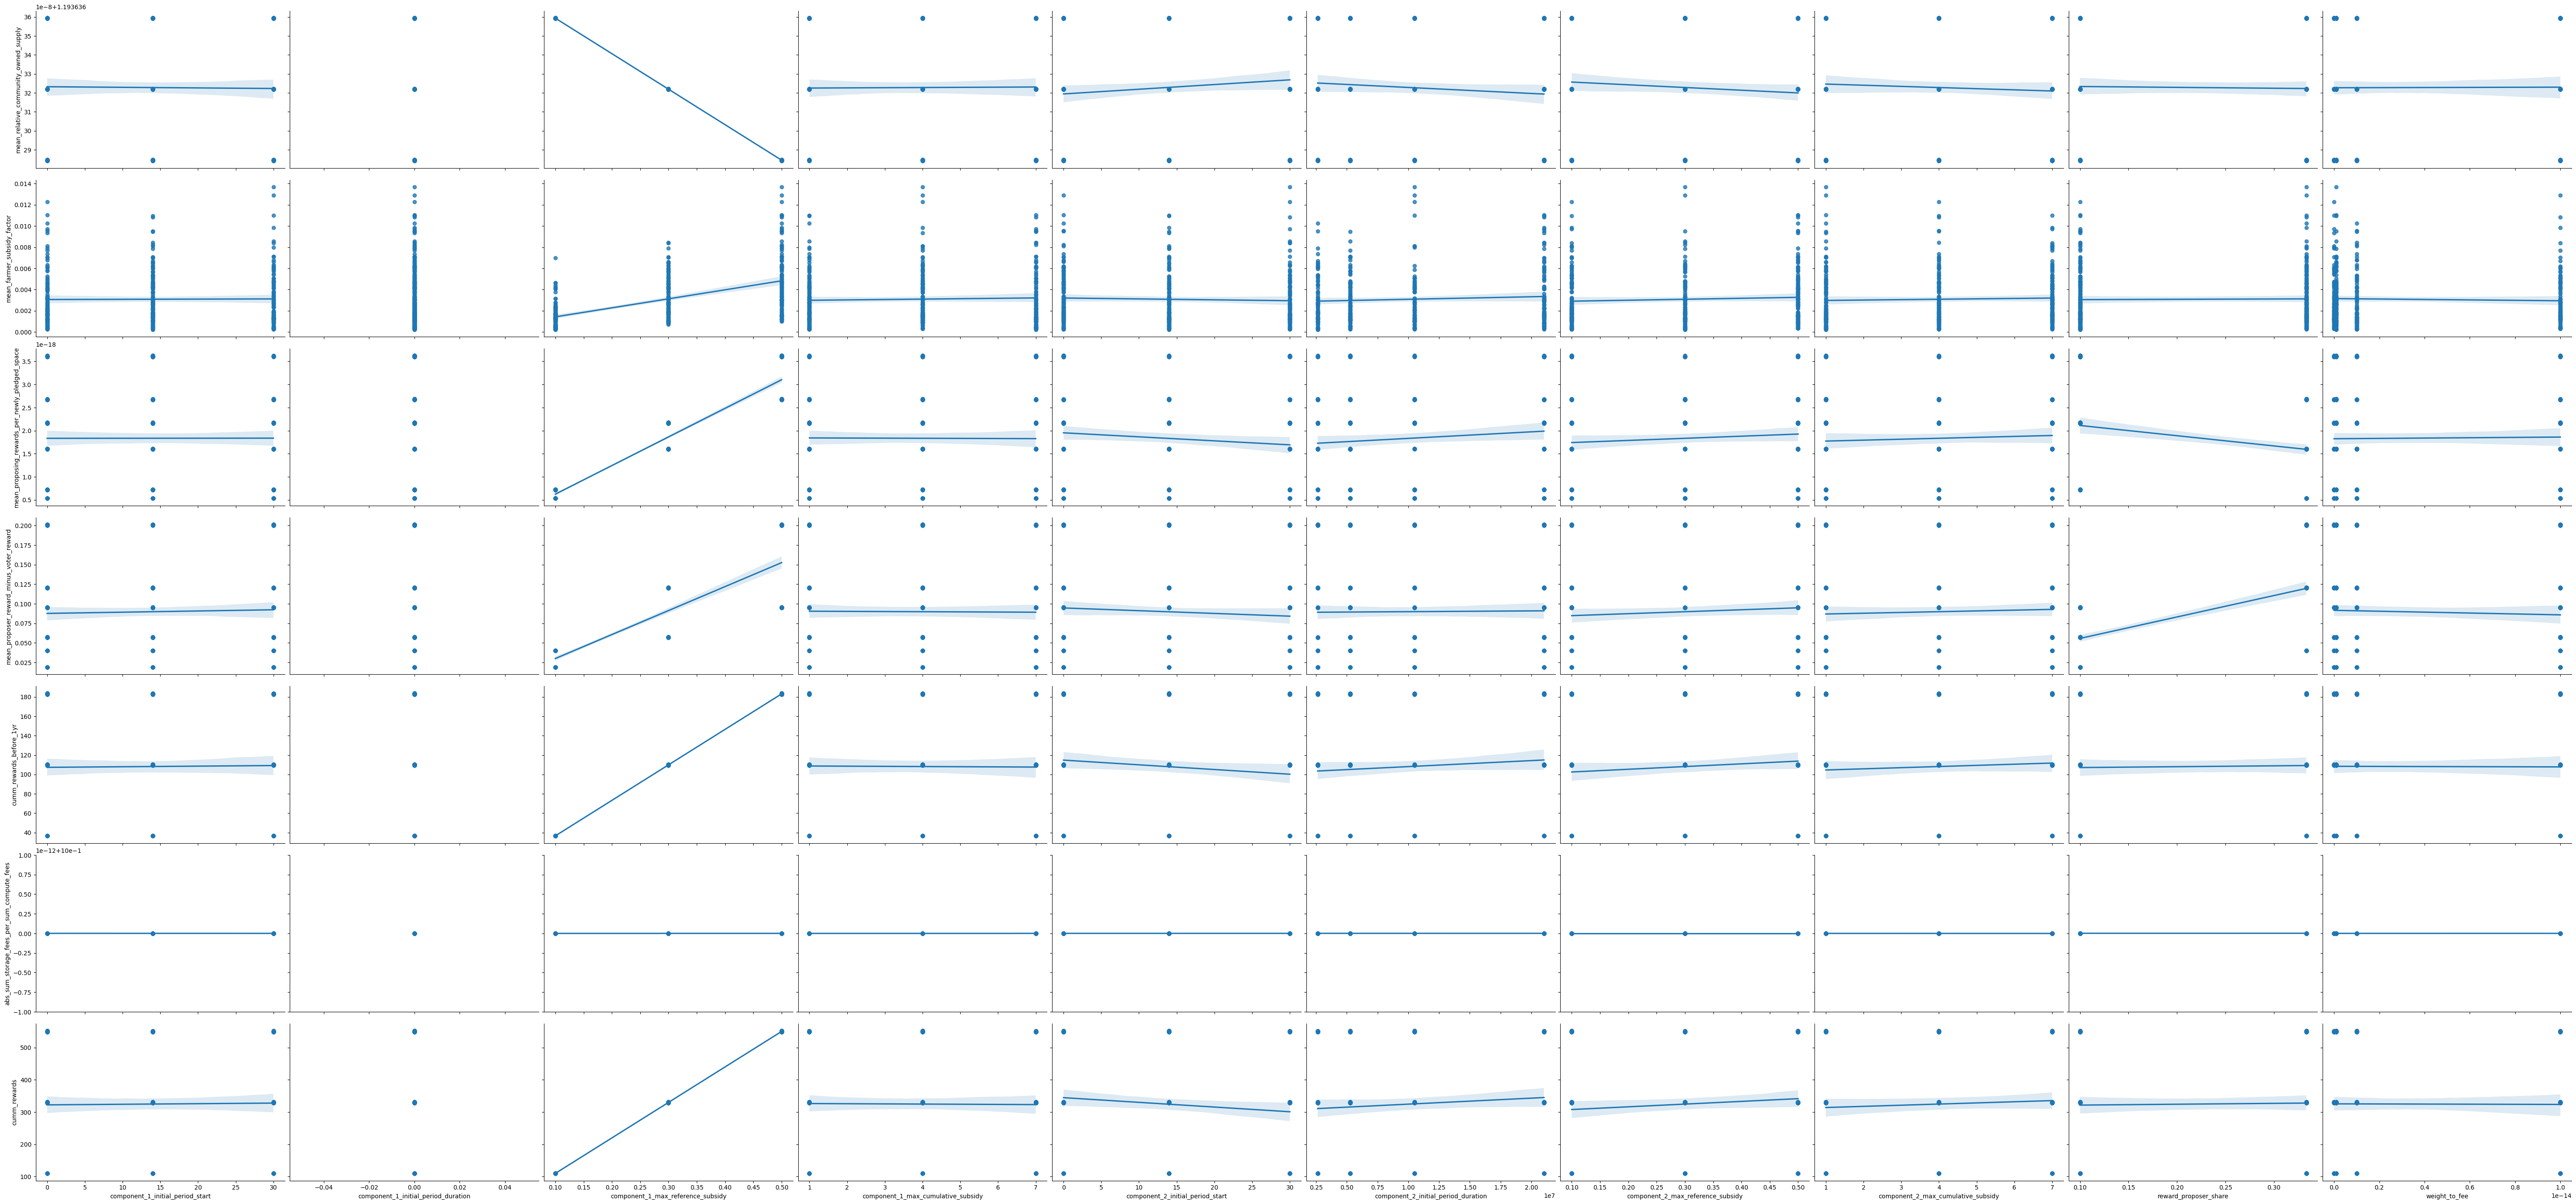

In [9]:
import seaborn as sns

N_params = len(GOVERNANCE_SURFACE_PARAMS)
N_kpis = len(KPI_functions)

N_rows = N_kpis
N_cols = N_params
HEIGHT = 4.0
ASPECT = 1.5

sns.pairplot(data=agg_df, 
             x_vars=GOVERNANCE_SURFACE_PARAMS, 
             y_vars=list(KPI_functions.keys()),
             height=HEIGHT,
             aspect=ASPECT,
             kind='hist')


sns.pairplot(data=agg_df, 
             x_vars=GOVERNANCE_SURFACE_PARAMS, 
             y_vars=list(KPI_functions.keys()),
             height=HEIGHT,
             aspect=ASPECT,
             kind='reg')


In [12]:
agg_df

simulation  subset  run  weight_to_fee  \
0             0       0    1   1.000000e-14   
1             0       1    2   1.000000e-14   
2             0       2    3   1.000000e-16   
3             0       3    4   1.000000e-16   
4             0       4    5   1.000000e-15   
..          ...     ...  ...            ...   
395           0     395   16   1.000000e-18   
396           0     396   17   1.000000e-16   
397           0     397   18   1.000000e-14   
398           0     398   19   1.000000e-15   
399           0     399   20   1.000000e-16   

     component_1_initial_period_duration  component_1_max_reference_subsidy  \
0                                      0                                0.1   
1                                      0                                0.3   
2                                      0                                0.5   
3                                      0                                0.1   
4                                      0                                0.3   
..                                   ...                                ...   
395                                    0                                0.3   
396                                    0                                0.3   
397                                    0                                0.1   
398                                    0                                0.3   
399                                    0                                0.3   

     component_2_initial_period_start  reward_proposer_share  \
0                                  30               0.333333   
1                                  30               0.100000   
2                                  14               0.333333   
3                                  14               0.333333   
4                                   0               0.333333   
..                                ...                    ...   
395                                14               0.333333   
396                                14               0.100000   
397                                 0               0.333333   
398                                14               0.333333   
399                                30               0.100000   

     component_2_max_cumulative_subsidy  component_2_initial_period_duration  \
0                                     1                            2628000.0   
1                                     1                            5256000.0   
2                                     1                           10512000.0   
3                                     1                            5256000.0   
4                                     7                           10512000.0   
..                                  ...                                  ...   
395                                   7                           21024000.0   
396                                   4                            2628000.0   
397                                   1                            2628000.0   
398                                   7                            5256000.0   
399                                   7                           10512000.0   

     component_2_max_reference_subsidy  component_1_max_cumulative_subsidy  \
0                                  0.1                                   1   
1                                  0.3                                   1   
2                                  0.1                                   4   
3                                  0.3                                   4   
4                                  0.3                                   4   
..                                 ...                                 ...   
395                                0.5                                   1   
396                                0.5                                   1   
397                                0.5                     

In [14]:
for k in KPI_functions.keys():
    c = agg_df[k].value_counts()
    if len(c) <= 10:
        print(c)

abs_sum_storage_fees_per_sum_compute_fees
1.0    400
Name: count, dtype: int64


In [21]:
d = agg_df[KPI_functions.keys()].describe().T
d['mean']

mean_relative_community_owned_supply              1.193636e+00
mean_farmer_subsidy_factor                        3.084661e-03
mean_proposing_rewards_per_newly_pledged_space    1.835567e-18
mean_proposer_reward_minus_voter_reward           8.991451e-02
cumm_rewards_before_1yr                           1.082207e+02
abs_sum_storage_fees_per_sum_compute_fees         1.000000e+00
cumm_rewards                                      3.251426e+02
Name: mean, dtype: float64

In [22]:
d['std'] / d['mean']

mean_relative_community_owned_supply              2.524969e-08
mean_farmer_subsidy_factor                        7.999450e-01
mean_proposing_rewards_per_newly_pledged_space    5.699717e-01
mean_proposer_reward_minus_voter_reward           6.752627e-01
cumm_rewards_before_1yr                           5.455254e-01
abs_sum_storage_fees_per_sum_compute_fees         0.000000e+00
cumm_rewards                                      5.452626e-01
dtype: float64